
# Bayesian Hierarchical drift-diffusion modelling: A primer
Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com


This is the script for illustrating a principled workflow of hierarchical bayesian drift diffusion modelling. We used data from Cavanagh et al.(2011) as an example.This dataset had been used in Wiecki et al (2013).


## About the dataset
### Participants
14 patients with Parkinsons' disease. 12 males, 2 females, age range (46 ~ 77 years).

### Experimental design

Two within-subject design: 
Independent variable: DBS on vs DBS off;
Independent variable: high (win-win; lose-lose) vs. low conflict (win-lose).

Dependent variable:
RT and response.

### Procedure

![Task dynamics](./Cavanagh_2011_procedure.png)

The above figure is from Cavanagh et al (2011)'s figure 1b. The experiment include two session: training and test. During training, participants learned to choose one item in each pair (termed A/B and C/D) that was reinforced more often (A/B, 100%/0%; C/D, 75%/25%). In example below, the butterfly might be A and the piano might be B. During testing, participants had to choose the better stimulus, leading to high-conflict choices for win-win (A/C) and lose-lose (B/D) as well as low-conflict choices (A/D, C/B). For example, if the cake was C in training, this would reflect a high-conflict win-win cue.

Only the testing data are available and used here in this primer.

**Reference of the data**

Cavanagh, J. F., Wiecki, T. V., Cohen, M. X., Figueroa, C. M., Samanta, J., Sherman, S. J., & Frank, M. J. (2011). Subthalamic nucleus stimulation reverses mediofrontal influence over decision threshold. Nature Neuroscience, 14(11), 1462–1467. https://doi.org/10.1038/nn.2925

Wiecki, T. V., Sofer, I., & Frank, M. J. (2013). HDDM: Hierarchical Bayesian estimation of the Drift-Diffusion Model in Python. Frontiers in Neuroinformatics, 7. https://doi.org/10.3389/fninf.2013.00014

## Step 1: Install HDDM

Here we will check the version of the package to make sure that HDDM works.

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


### Loading data and explore the data

The data is from `HDDM` package itself, but it was hidden in the `examples` folder, uncomment the following code to find it out:

In [2]:
# # find the directory of "cavanagh_theta_nn.csv"
# print(hddm.__file__)
# !head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

In [242]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


### Check the number of trials for each condition

Way 1: grouped by `stim`

In [4]:
data.groupby(['subj_idx']).size()

subj_idx
0     298
1     298
2     293
3     255
4     283
5     303
6     299
7     294
8     293
9     217
10    309
11    305
12    267
13    274
dtype: int64

In [5]:
data.groupby(['subj_idx', 'stim', 'dbs']).size()

subj_idx  stim  dbs
0         LL    0      36
                1      37
          WL    0      74
                1      77
          WW    0      38
                       ..
13        LL    1      39
          WL    0      62
                1      73
          WW    0      32
                1      39
Length: 84, dtype: int64

Way 2: grouped by `conf`

In [6]:
data.groupby(['subj_idx', 'conf', 'dbs']).size()

subj_idx  conf  dbs
0         HC    0      74
                1      73
          LC    0      74
                1      77
1         HC    0      70
                1      75
          LC    0      77
                1      76
2         HC    0      77
                1      69
          LC    0      78
                1      69
3         HC    0      68
                1      58
          LC    0      71
                1      58
4         HC    0      73
                1      66
          LC    0      75
                1      69
5         HC    0      77
                1      71
          LC    0      77
                1      78
6         HC    0      75
                1      70
          LC    0      78
                1      76
7         HC    0      75
                1      77
          LC    0      69
                1      73
8         HC    0      73
                1      72
          LC    0      73
                1      75
9         HC    0      57
                1 

## Step 2: Visualize the raw data

Way 1: Original way

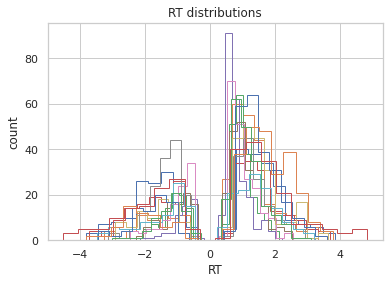

In [110]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Way 2: Interactive with plotly

### Visualize the summary results
Here we can reproduce part of Figure 3 in Cavanagh et al. (2011).

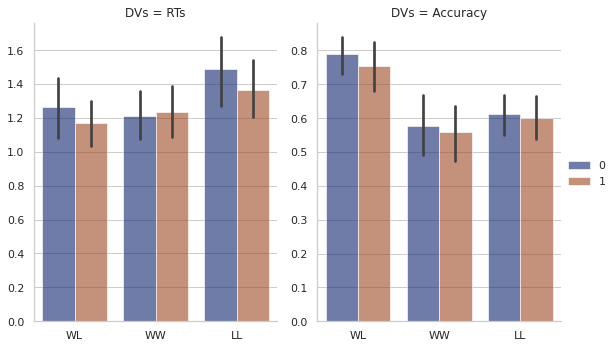

In [8]:
# get the median of accurate RTs
data_rt_sum = data[data['response'] ==1].groupby(['subj_idx','dbs', 'stim'])['rt'].median().reset_index()

# get the mean accuracy (this approach is not optimal)
data_acc_sum = data.groupby(['subj_idx','dbs', 'stim'])['response'].mean().reset_index()

data_rt_sum['DVs'] = 'RTs'
data_rt_sum.rename(columns={'rt':'value'}, inplace=True)
data_acc_sum['DVs'] = 'Accuracy'
data_acc_sum.rename(columns={'response':'value'}, inplace=True)

data_sum = pd.concat([data_rt_sum, data_acc_sum]).reset_index(drop=True)  # concat two dataframes

# # categorize the cond and order the data
from pandas.api.types import CategoricalDtype

stim_type = CategoricalDtype(categories=['WL', 'WW', 'LL'],
                           ordered=True)
data_rt_sum['stim'] = data_rt_sum['stim'].astype(stim_type)
data_acc_sum['stim'] = data_acc_sum['stim'].astype(stim_type)
data_sum['stim'] = data_sum['stim'].astype(stim_type)

### MUST use map_dataframe()
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(data=data_sum, col="DVs", height=5, aspect=.8, sharex=True, sharey=False)
g.map_dataframe(sns.barplot, x='stim', y="value", hue = 'dbs', 
                #order=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                #ci = 'sd', # not used, boostrap confidence interval will be used?
                palette="dark", alpha=.6,)
g.add_legend()

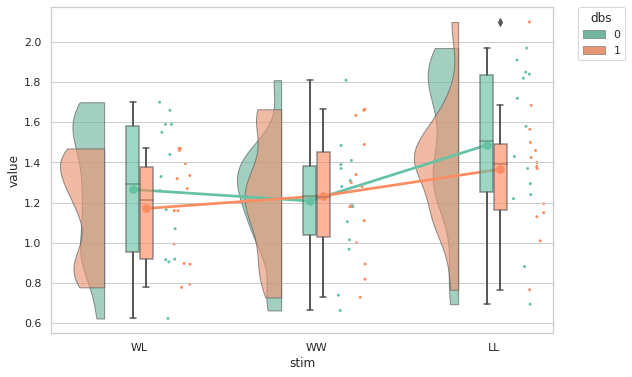

In [9]:
# plot raincloud of RT
import ptitprince as pt

dx = "stim"; dy = "value"; dhue = "dbs"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

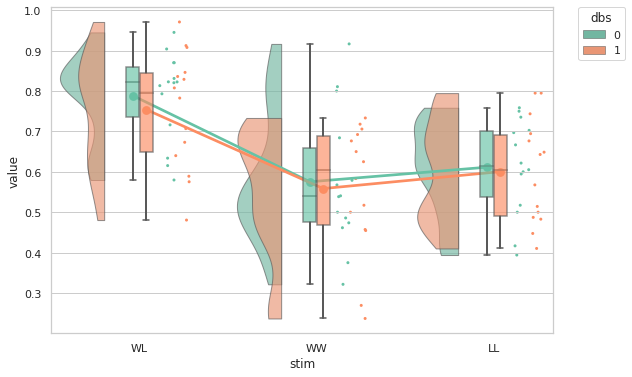

In [10]:
f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_acc_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

In [11]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, 
#                                ncols=2, 
#                                figsize=(12, 6),
#                                sharex=True,
#                                sharey=False)

# ax1 = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
#                   bw=sigma, width_viol=.5,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

# ax2 = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_acc_sum, palette=pal, 
#                   bw=sigma, width_viol=.5,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

# plt.show()

## Step 3: Prior predictive check

See `HDDM_Primer_SM_Prior_Check.ipynb`

## Step 4: Model specification

Model specification is for demonstration purpose.

Here we used models that already showed in previous tutorial, but with more details.

### M0: Baseline model: simplified model

In this model, we only fit a basic hierarchical DDM model, we assume that all the parameters are not varied across any condition.

`m0_0 = HDDM(data)`

$$x_{ij} \sim wfpt(a_j, v_j, t_j, z_j, sv, st, sz)$$
$$v_j \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z = 0.5 $$
$$sv = 0 $$
$$st = 0 $$
$$sz = 0 $$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

### M1: Baseline model: full model

`m1 = HDDM(data, include=['z', 'sv', 'sz', 'st'])`

$$x_{ij} \sim wfpt(a_j, v_j, t_j, z_j, sv, st, sz)$$
$$v_j \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

A graphical representation of this model is simpler than the graph appeared in [Wiecki et al, 2013](https://github.com/hddm-devs/hddm/blob/master/docs/paper/graphical_hddm.svg)):

![Graph_m0](./model_graphs/model_graph_basic.svg)


### M2: Depends_on conflict level, full model
In this model, we will use different `v` for different conflict levels, but keep all the other variables' at group level. By doing so, we added one additional level to the model ---- conditions. And this level has two levels: high vs. low. However, for the prior distribution, $v_{j, p}$ share the same priors.

`m2 = HDDM(data, depends_on={'v': 'conf'}, include = ['z', 'sv', 'sz', 'st'])`

$$x_{i, k, j} \sim wfpt(a_j, v_{k, j}, t_j, z_j, sv, st, sz)$$

$$v_{k, j} \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

[Insert graph of m1 here]

### M3: Regressed on conflict level (varying intercept)
In regression models, HDDM can be viewed as a hierarchical generalized linear model. Thus, experiences with generalized hierarchical linear model can be useful.

In previous tutorial, Wiecki et al (2011) demonstrated how to use regression model using `dummy coding` or `treatment coding`. There are also other coding schema available in `patsy`


`m3 = HDDMRegressor(data, "v ~ C(conf, Treatment('LC'))", group_only_regressors=True, include = ['z', 'sv', 'sz', 'st'])`

$$x_{i, k, j} \sim wfpt(a_j, v_{k, j}, t_j, z_j, sv, st, sz)$$

$$v_{k, j} = v_{j_{intercept}} + v_{k_{beta}} * Treatment_k$$

$$v_{j_{intercept}} \sim N(\mu_v, \sigma_v^2)$$
$$v_{k_{beta}} \sim N()$$

$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$ \alpha_v \sim N(\mu_v, \sigma_v^2)$$
$$ \beta_v \sim N()$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$


* Contrast vs. variable. In Statistical rethings (page 157, 159), Richard distinguished `indicator variable` and `index variable` and recommended `index variable`. What is the relationship between these two and different contrast (design matrix)?

Now we need to have a bit tour on `patsy`. `patsy` used the grammar that may familiar to those who use `lme4` or related packages (e.g., `brms`).

Very briefly, the grammar of `patsy` is like this:

$$ y \sim a + b*x$$

The left hand side of $\sim$ is the variable need to be predicted, which is usually the outcome (i.e., parameters of DDM in HDDM). the right hand side of the $\sim$ is the predictors. please see the [document of `patsy`](https://patsy.readthedocs.io/en/latest/formulas.html) for more, or see https://arxiv.org/abs/1911.08628 for a more general explanation for MLM.

In `patsy`, the function`dmatrices` can give the design matrix with both the dependent variable on the lefthand side of the formual and the right hand side of the formula, which two parts are delimiited by `~` .

If we are only interested in the right hand side of the formula, which is we usually do, we need `dmatrix`.

As mentioned in `patsy` API, `patsy` has implemented several widely-used way to handle categorical data. 

The most-widely used one is "treatment contrast". 

The `reduced rank` and `full rank` are not familiar to readers from psychology. `redcued rank` is the design matrix with `intercept`, i.e., one level of the condition is selected as a reference. This `reduced rank` is the traditional meaning of `dummy coding` in psychology. `full rank` is the design without a reference, the each column of the resulting matrix represents the mean of the corresponding level. This way of coding is the call `cell mean` . 

In [12]:
from patsy import dmatrix, demo_data
demo = demo_data("a", "b", "x1", "x2", "y", "z column")

In [13]:
dmatrix("x1 + x2", demo)

DesignMatrix with shape (8, 3)
  Intercept        x1        x2
          1   1.76405  -0.10322
          1   0.40016   0.41060
          1   0.97874   0.14404
          1   2.24089   1.45427
          1   1.86756   0.76104
          1  -0.97728   0.12168
          1   0.95009   0.44386
          1  -0.15136   0.33367
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)

In [14]:
# show first 20 row of design matrix
dmatrix("C(conf, Treatment('LC'))", data.head(20))

# or using DataFrame:
#pd.DataFrame(dmatrix("C(conf, Treatment('LC'))", data))

DesignMatrix with shape (20, 2)
  Intercept  C(conf, Treatment('LC'))[T.HC]
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               1
          1                               0
          1                               0
          1                               1
          1                               0
          1                               0
          1                               0
  Terms:
    'Intercept' (column 0)
    "C(c

### M4: Regressed on conflict level (varying intercept and varying slope)

```
m3 = hddm.HDDMRegressor(data, "v ~ C(conf, Treatment('LC'))", group_only_regressors=False)
```

### M5: Using theta as an additional predictor of `a`
```
m4 = hddm.HDDMRegressor(data[data.dbs == 0],
                        "a ~ theta:C(conf, Treatment('LC'))",
                        depends_on={'v': 'conf'})
```

### M6: Regression for both parameters
```
m6 = hddm.HDDMRegressor(data[data.dbs == 0],
                        "a ~ theta:C(conf, Treatment('LC')),
                         v ~ C(conf, Treatment('LC'))")
```

Two issues that persisted in the users' forum:
* Should we use `HDDMRegressor` whenever the design is within-subject?
* Do we need to start from the `full model` as suggested by some articles on linear mixed model?

### M7: Regression for three parameters

In the tutorial, Cavanagh modelled dbs on and off separately, can we model them in one model?

```
m7 = hddm.HDDMRegressor(data[data.dbs == 0],
     ["a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0')),
     v ~ C(conf, Treatment('LC'))"])
```

Two issues that persisted in the users' forum:
* Should we use `HDDMRegressor` whenever the design is within-subject?
* Do we need to start from the `full model` as suggested by some articles on linear mixed model?

In [15]:
pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", data)).head()

,0,1,2,3,4
0,1.0,0.0,0.0,0.656275,0.000000
1,1.0,-0.0,-0.0,-0.000000,-0.327889
2,1.0,-0.0,-0.0,-0.480285,-0.000000
3,1.0,0.0,0.0,0.000000,1.927427
4,1.0,-0.0,-0.0,-0.213236,-0.000000


In [16]:
pd.DataFrame(dmatrix("0 + theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", data))

,0,1,2,3
0,0.000000,0.000000,0.656275,0.000000
1,-0.000000,-0.000000,-0.000000,-0.327889
2,-0.000000,-0.000000,-0.480285,-0.000000
3,0.000000,0.000000,0.000000,1.927427
4,-0.000000,-0.000000,-0.213236,-0.000000
...,...,...,...,...
3983,-1.237166,-0.000000,-0.000000,-0.000000
3984,-0.000000,-0.377450,-0.000000,-0.000000
3985,-0.000000,-0.694194,-0.000000,-0.000000
3986,-0.546536,-0.000000,-0.000000,-0.000000


## Step 5: Simulation, parameter recovery, and model recovery

See `HDDM_Primer_SM_Params_Recov.ipynb`


## Step 6: Model estimation with real data
We used parallel processing by `p_tqdm`.

In [17]:
%%time

# define a function to run model in parallel

# M0_0: base model: simplified
def run_m0(id, df=None, samples=None, burn=None, save_name="ms0"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M1: base model: full model
def run_m1(id, df=None, samples=None, burn=None, save_name="ms1"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M2: treat within-subj as between-subj: full model
def run_m2(id, df=None, samples=None, burn=None, save_name="ms2"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def run_m3(id, df=None, samples=None, burn=None, save_name="ms3"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def run_m4(id, df=None, samples=None, burn=None, save_name="ms4"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M5: regression model + theta as an additional predictor of `a`
def run_m5(id, df=None, samples=None, burn=None, save_name="ms5"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDMRegressor(df,
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'conf'},
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M6: Regression for both parameters
def run_m6(id, df=None, samples=None, burn=None, save_name="ms6"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M7: Regression for both parameters
def run_m7(id, df=None, samples=None, burn=None, save_name="ms7"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


Here we define a function to run the model, get posterior, generate posterior predictive, and calculate the point-wise log likelihood. The steps inside can be executed separately too.

Note, I recommend users to run the modelling part using python script directly instead of in jupyter notebook.

`python -W ignore Run_all_models.py --samples 15000 --burn 7000 --nppc 1000 --chains 4 --test 0 --save 1`

In [18]:
samples = 25000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 10000     
nppc = 1000     # 1000 samples for posterior predictive, super slow
thin = 3
chains = 4
test_mode = True

In [19]:
%%time

## total time: 5h 19s when test_mode is False

## Step 1: run models in parallel
file_path = "/home/jovyan/hddm/temp/"

if test_mode:
#     model_func = [run_m2, run_m5, run_m7]
    
#     m_keys = ["ms2",
#               "ms5",
#               "ms7"]
    
#     models = {"ms2": [], 
#               "ms5": [], 
#               "ms7": []}

    model_func = [run_m7]
    
    m_keys = ["ms7"]
    
    models = {"ms7": []}

    
else: 
    model_func = [run_m0, run_m1, run_m2, run_m3, 
                  run_m4, run_m5, run_m6, run_m7]

    # models = [[]] * len(model_func) hcp, using list in list is very tricky here, when loading 
    # models by for loop, it will end up with each list in the list "models" has 32 elements. 

    m_keys = ["ms0", "ms1", "ms2",
              "ms3", "ms4", "ms5",
              "ms6", "ms7"]
        
    models = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}

for ii in range(len(model_func)):
    #print(model_func[ii])
    #print(model_name[ii])
    file_full_path = file_path + "/" + m_keys[ii] + "_tmp1_chain_*[!db]" 
    # print(file_full_path)
    file_names = glob.glob(file_full_path, recursive=False)
    print(file_names)
    
    if file_names:
        for jj in file_names:
            print('current loading: ', jj, '\n')
            models[m_keys[ii]].append(hddm.load(jj))
    else:
        print('current estimating:', m_keys[ii])
        models[m_keys[ii]] = p_map(partial(model_func[ii], df=data, samples=samples, 
                                         burn=burn),
                                 range(chains))

['/home/jovyan/hddm/temp/ms7_tmp1_chain_3', '/home/jovyan/hddm/temp/ms7_tmp1_chain_2', '/home/jovyan/hddm/temp/ms7_tmp1_chain_0', '/home/jovyan/hddm/temp/ms7_tmp1_chain_1']
current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_3 

current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_2 

current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_0 

current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_1 

CPU times: user 30.8 s, sys: 1.76 s, total: 32.5 s
Wall time: 33.1 s


Getting the posterior traces for Inference Data

In [20]:
%%time

## step 2: Get posterior trace

if test_mode:
#     df_traces = {"ms2": [], 
#                  "ms5": [],
#                  "ms7": []}
    df_traces = {"ms7": []}
else:
    df_traces = {"ms0": [], "ms1": [], "ms2": [], 
                 "ms3": [], "ms4": [], "ms5": [],
                 "ms6": [], "ms7": []}

for key, model in models.items():
#    ms = models[m_keys[ii]]
    print(key)
#     print(df_traces[m_keys[ii]])
    trace_tmp = []
    for jj in range(len(model)):
        trace_tmp = model[jj].get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
        df_traces[key].append(trace_tmp)
    df_traces[key] = pd.concat(df_traces[key])

ms7
CPU times: user 31.6 ms, sys: 28 ms, total: 59.5 ms
Wall time: 59.4 ms


In [21]:
from p_tqdm import p_map
from functools import partial

# NOTE: I hacked the `post_pred_gen`, 
# more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

from pointwise_loglik_gen import _pointwise_like_generate
from pointwise_loglik_gen import pointwise_like_gen

### PPC

The original PPC function was revise so that (1) the default number of samples of the PPC is the same as MCMC in model fitting; (2) every draw in the posterior will be used for PPC, instead of randomly select from all posteriors.

In [22]:
%%time

## total time: 1d 6h 12min 5s when test_mode is False

if test_mode:
#     df_ppc   = {"ms2": [], 
#                  "ms5": [],
#                  "ms7": []}
    df_ppc   = {"ms7": []}
else:  
    df_ppc = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}
#     m_keys = ["df_ppc_0", "df_ppc_1", "df_ppc_2", 
#                 "df_ppc_3", "df_ppc_4", "df_ppc_5", 
#                 "df_ppc_6", "df_ppc_7"]

for ii in range(len(m_keys)):
    key = m_keys[ii]
    value = df_ppc[m_keys[ii]]
    
    if not bool(value):
        print("No PPC values, try to get feather file names")
        # read ftr filenames
        ftr_path = file_path + "df_" + key + "_tmp1_ppc_chain_*ftr" 
        ftr_names = glob.glob(ftr_path, recursive=False)
#         print(ftr_names)
        
        # if there are ftr files
        if ftr_names:
            print("Got feather file names, loading the PPC")
            for ftrname in ftr_names:
#             for f_id in range(len(ftr_names)):
                print("loading \n", ftrname)
                df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
                df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
                df_ppc[key].append(df_tmp)     
        else:
            print("No feather files either, run PPC now ...")
#             for ii in range(len(m_keys)):
            ms = models[m_keys[ii]]
            print("Generating PPC ", key, "for", m_keys[ii])
            start_time = time.time()  # the start time of the processing
        #     df_ppc[m_keys[ii]] = p_map(partial(post_pred_gen, samples = 500), ms)
            df_ppc[key] = p_map(partial(post_pred_gen), ms)

            print("Running PPC costs %f seconds" % (time.time() - start_time))
            
            print("Save PPC to feather files")
            for chain in range(len(df_ppc[key])):
                ftrname = file_path + "df_" + key + "_ppc_chain_" + str(chain) + ".ftr"
                print(ftrname)
                df_ppc[key][chain].reset_index().to_feather(ftrname)
    else:
        continue

No PPC values, try to get feather file names
Got feather file names, loading the PPC
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_0.ftr
CPU times: user 1.61 s, sys: 1.72 s, total: 3.34 s
Wall time: 3.1 s


### Point-wise log-likelihood (PLL)

Calculate the pll based on `node`

In [23]:
%%time

## total time: 2h 38min 51s when test_mode is False

if test_mode:
#     df_pll = {"ms2": [],
#               "ms5": [],
#               "ms7": []}  
    df_pll = {"ms7": []} 
    
else:
    df_pll = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}  
#     m_keys = ["df_pll_0", "df_pll_1", "df_pll_2",
#                 "df_pll_3", "df_pll_4", "df_pll_5",
#                 "df_pll_6", "df_pll_7"]

for ii in range(len(m_keys)):
    key = m_keys[ii]
    value = df_pll[m_keys[ii]]

    if not bool(value):
        print("\nNo loglik values, try to get feather file names")
        # read ftr filenames
        ftr_path = file_path + "df_" + key + "_tmp1_pll_chain_*ftr" 
        ftr_names = glob.glob(ftr_path, recursive=False)
        # print(ftr_names)
        
        # if there are ftr files
        if ftr_names:
            print("Got feather file names, loading the loglik files")
            for ftrname in ftr_names:
                print("loading \n", ftrname)
                df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
                df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
                df_pll[key].append(df_tmp)
        else:
            print("No feather files either, run loglik now ...")

            ms = models[m_keys[ii]]
            print("Generating loglik ", key, "for", m_keys[ii])
            start_time = time.time()  # the start time of the processing
            # df_pll[m_keys[ii]] = p_map(partial(pointwise_like_gen, samples = 500), ms)
            df_pll[key] = p_map(partial(pointwise_like_gen), ms)

            print("Generating loglik costs %f seconds" % (time.time() - start_time))
            
            print("Save loglik to feather files")
            for chain in range(len(df_pll[key])):
                ftrname = file_path + "df_" + key + "_tmp1_pll_chain_" + str(chain) + ".ftr"
                print(ftrname)
                df_pll[key][chain].reset_index().to_feather(ftrname)
    else:
        continue


No loglik values, try to get feather file names
Got feather file names, loading the loglik files
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_0.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_2.ftr
CPU times: user 6.95 s, sys: 8.27 s, total: 15.2 s
Wall time: 14.4 s


### Covert PPC and log-likelihood to InferenceData

In [24]:
%%time

if test_mode:
#     InfData = {"ms2": [], 
#                  "ms5": [],
#                  "ms7": []}
    InfData = {"ms7": []} 
    
else:
    InfData = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}  
#     m_keys = ["InfData_0", "InfData_1", "InfData_2",
#                 "InfData_3", "InfData_4", "InfData_5",
#                 "InfData_6", "InfData_7"]

for ii in range(len(models)):
    obs_data = models[m_keys[ii]][0].data.copy()
    obs_data.index.names = ['trial_idx']
    if 'conf' in obs_data.columns:
        obs_data.drop(['subj_idx','stim', 'theta','dbs','conf'], axis=1, inplace=True)
    xdata_observed = xr.Dataset.from_dataframe(obs_data)

    df_traces_tmp = df_traces[m_keys[ii]].set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)
    
    df_ppc_tmp = pd.concat(df_ppc[m_keys[ii]], names=['chain'], 
                            keys = list(range(len(df_ppc[m_keys[ii]]))))
#     df_ppc_tmp['response'] = df_ppc_tmp['response'].astype('float')
    df_ppc_tmp = df_ppc_tmp.reset_index(level=1, drop=True)
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)
    
    df_pll_tmp = pd.concat(df_pll[m_keys[ii]], names=['chain'], 
                            keys = list(range(len(df_pll[m_keys[ii]]))))
    df_pll_tmp = df_pll_tmp.reset_index(level=1, drop=True)
    xdata_loglik = xr.Dataset.from_dataframe(df_pll_tmp)
    
    InfData[m_keys[ii]] = az.InferenceData(posterior=xdata_posterior, 
                                             observed_data=xdata_observed,
                                             posterior_predictive=xdata_post_pred,
                                             log_likelihood = xdata_loglik)

CPU times: user 15.9 s, sys: 3.99 s, total: 19.8 s
Wall time: 19.9 s


## Step 7: Diagnosis of models

Here we check convergence and other aspects of each model.

In [25]:
InfData['ms7']

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [26]:
%%time

ms7_rhat = az.rhat(InfData['ms7'],method='rank')
ms7_rhat

CPU times: user 981 ms, sys: 9.87 ms, total: 991 ms
Wall time: 1.07 s


<xarray.Dataset>
Dimensions:                                                                 ()
Data variables: (12/147)
    t                                                                       float64 ...
    t_std                                                                   float64 ...
    t_subj.0                                                                float64 ...
    t_subj.1                                                                float64 ...
    t_subj.2                                                                float64 ...
    t_subj.3                                                                float64 ...
    ...                                                                      ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.8                                 float64 ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.9                                 float64 ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.10                                float64 ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.11                                float64 ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.12                                float64 ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.13                                float64 ...

#### Using the `az.summary()` function

`az.summary()` provides many information about the model convergence.

As we can see below, model's convergence is not perfect, which is not surprising giveing that we only used 2000 samples.

In [27]:
ms7_summary = az.summary(InfData['ms7'])
ms7_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.619,0.035,0.553,0.688,0.000,0.000,7059.0,11350.0,1.00
"a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.8",-0.041,0.053,-0.145,0.063,0.001,0.000,6298.0,11303.0,1.00
"a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.9",-0.032,0.059,-0.149,0.081,0.001,0.001,6657.0,10757.0,1.00
"a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.10",-0.045,0.056,-0.158,0.060,0.001,0.000,6129.0,11657.0,1.00
"a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.11",-0.025,0.059,-0.130,0.101,0.001,0.001,6093.0,10836.0,1.00
...,...,...,...,...,...,...,...,...,...
"a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]",0.047,0.031,-0.013,0.106,0.001,0.001,1590.0,1566.0,1.00
a_Intercept_subj.8,1.985,0.074,1.846,2.121,0.001,0.000,11143.0,16222.0,1.00
"v_C(conf, Treatment('LC'))[T.HC]_std",0.148,0.072,0.000,0.263,0.002,0.001,899.0,363.0,1.01
"a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_std",0.039,0.031,0.000,0.095,0.001,0.001,614.0,506.0,1.01


#### Visualize the convergence using `arviz.plot_trace()`

CPU times: user 2.07 s, sys: 20.5 ms, total: 2.09 s
Wall time: 2.12 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed2fb39d0>,
      dtype=object)

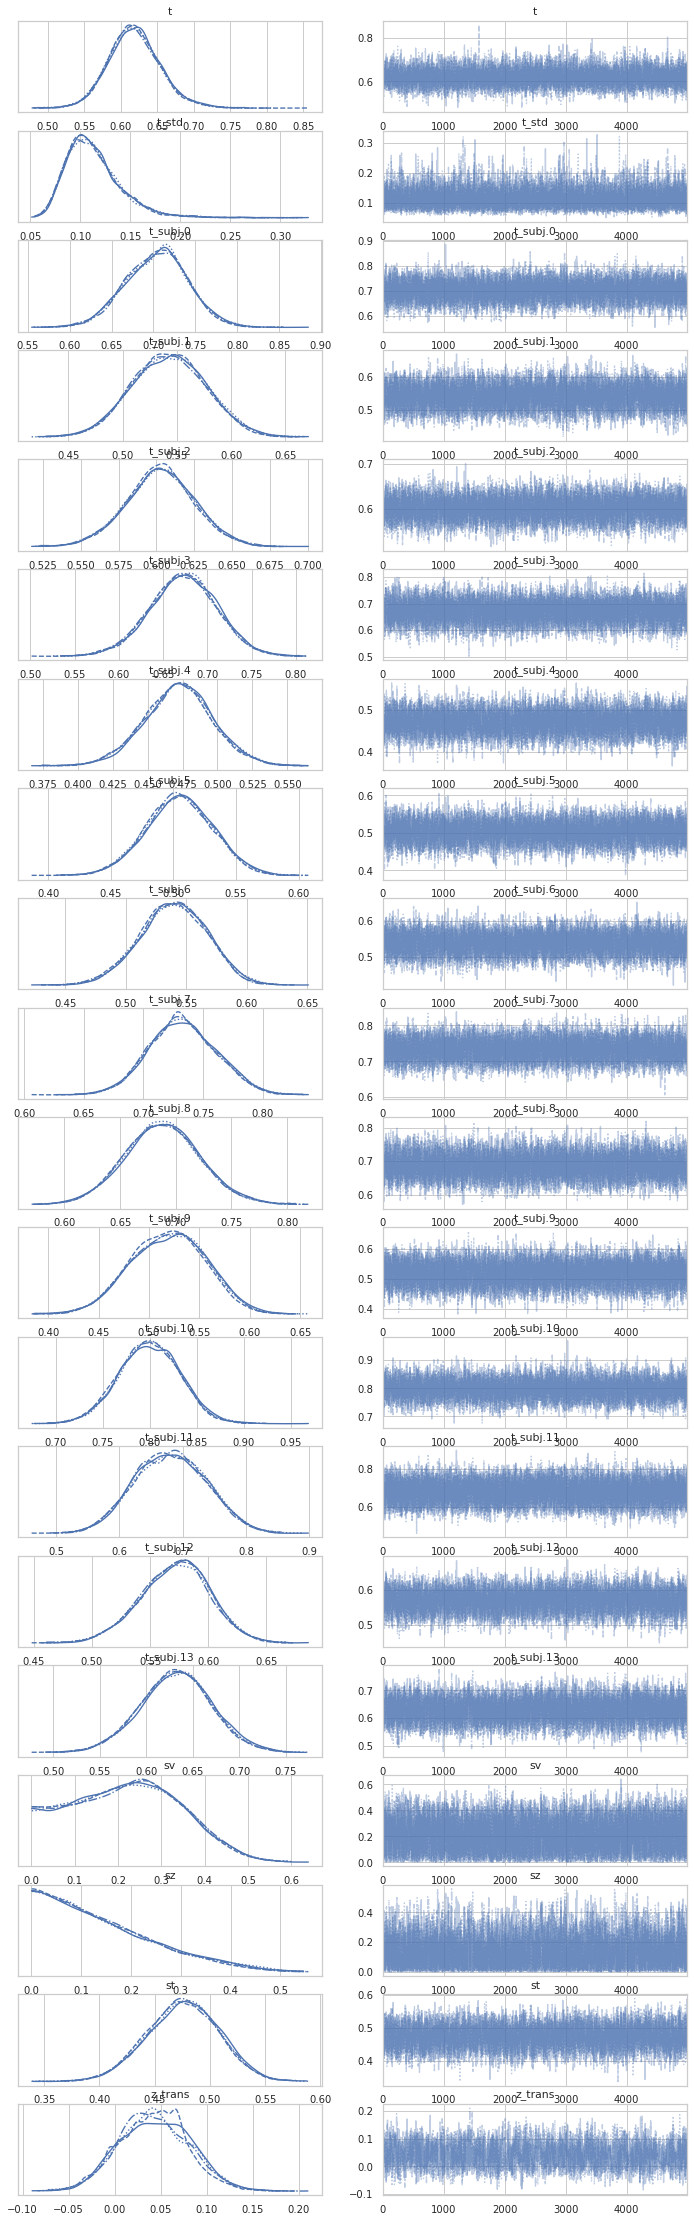

In [28]:
%%time
az.plot_trace(InfData['ms7'])

Note that there are other methods for diagnostic (`arviz.bfmi()`,  are not suitable for HDDM because `pymc2.3.8` does not use NUTS or HMC for sampling.

## Step 8: Model comparison

*Make sure that all models have good convergence before we conduct model comparison.*

We will use multiple ways for model comparison: `dic`, `psis-loo`, and `waic`.

In [37]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
#     print(len(models[key]))
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
#     print(m_key + "'s DIC: ", m_tmp.dic) # model 4 has the lowest DIC
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

CPU times: user 56.1 s, sys: 869 ms, total: 57 s
Wall time: 57.8 s


,rank,dic
0,ms4,10654.245810
1,ms2,10655.552957
2,ms6,10658.451262
3,ms5,10658.891710
4,ms3,10660.546884
5,ms7,10662.267253
6,ms1,10836.635533
7,ms0,10973.314282


In [38]:
comp_loo = az.compare(InfData, ic='loo')
comp_loo

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_s

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms6,0,-8123.528354,2726.699279,0.000000,4.388091e-02,1204.903886,0.000000,True,log
ms7,1,-8228.782821,2837.149268,105.254467,3.557839e-01,1261.998748,80.421240,True,log
ms4,2,-8297.971322,2893.923544,174.442968,2.467056e-01,1289.112799,119.057621,True,log
ms5,3,-8364.307382,2972.851603,240.779029,5.487297e-13,1300.545501,131.978513,True,log
ms3,4,-8484.178785,3069.749793,360.650431,3.254807e-13,1292.150468,215.424671,True,log
ms2,5,-8485.366172,3086.499587,361.837818,1.563809e-01,1343.165432,169.776464,True,log
ms1,6,-8692.752016,3192.038204,569.223663,0.000000e+00,1326.050446,219.116537,True,log
ms0,7,-14163.512004,8647.148950,6039.983650,1.972487e-01,2183.799501,2326.289332,True,log


In [44]:
comp_waic = az.compare(InfData, ic='waic')
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ms6,0,-12110.283733,6713.454658,0.000000,2.251007e-01,3538.631737,0.000000,True,log
ms7,1,-12224.632468,6832.984855,114.348736,0.000000e+00,3547.730388,224.101621,True,log
ms3,2,-12318.985138,6904.556146,208.701405,2.639383e-01,3685.863447,341.176780,True,log
ms4,3,-12409.405583,7005.357805,299.121850,0.000000e+00,3639.506634,343.805181,True,log
ms1,4,-12433.288338,6932.574525,323.004605,1.653398e-12,3488.464622,442.501832,True,log
ms5,5,-12524.265336,7132.809557,413.981603,1.608438e-01,3741.890825,281.877448,True,log
ms2,6,-12939.969296,7541.102711,829.685564,1.489208e-01,3905.118152,459.064124,True,log
ms0,7,-38859.053634,33342.690581,26748.769902,2.011964e-01,12338.733459,12791.416493,True,log


### PPC
Note that the `az.plot_ppc` only work data within `InferenceData`, which contain only the index of each trial in our case. To plot the PPC of each participant and each condition, we need to tweak the `az.plot_ppc` a bit.

Note0: because the `rt` data include both correct (positive) and errornous (negative) information, we will only plot the RT.

Note: the `Group` or `Matching variables` of `InferenceData` seems not enough for our purpose.

In `az.plot_ppc`, the most two import arguement are `obs_plotters` and `pp_plotters`, these two are the data will be plotted.

we can hack this part!

In [30]:
?az.plot_ppc

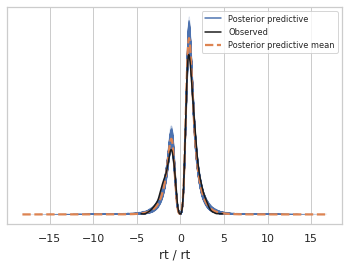

In [333]:
az.plot_ppc(InfData['ms7'], var_names = 'rt')

/opt/conda/lib/python3.7/site-packages/arviz/plots/ppcplot.py:225: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


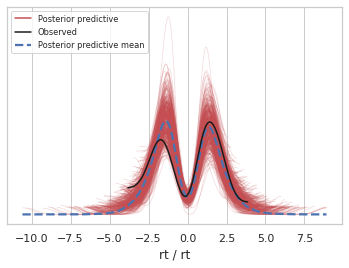

In [32]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "HC") & (data.dbs==1)].index
plot_infData = InfData['ms7'].isel(trial_idx=plot_index)
pp_subj0_HC_dbs1_ms7 = az.plot_ppc(plot_infData, 
                                   num_pp_samples=500, 
                                   random_seed=7, 
                                   color="r",
                                   colors=['r', 'k', 'b'],
                                   kind = "kde",
                                   var_names = "rt") # 

In [41]:
plot_infData

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [51]:
list(plot_infData.observed_data.dims.keys())

['trial_idx']

In [40]:
pp_subj0_HC_dbs1_ms7

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55ea2f1dd0>,
      dtype=object)

/opt/conda/lib/python3.7/site-packages/arviz/plots/ppcplot.py:225: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


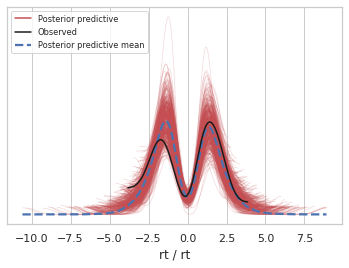

In [34]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "HC") & (data.dbs==1)].index
plot_infData = InfData['ms0'].isel(trial_idx=plot_index)
pp_subj0_HC_dbs1_ms0 = az.plot_ppc(plot_infData, 
                                   num_pp_samples=500, 
                                   random_seed=7, 
                                   color="r",
                                   colors=['r', 'k', 'b'],
                                   kind = "kde",
                                   var_names = "rt") # 

/opt/conda/lib/python3.7/site-packages/arviz/plots/ppcplot.py:225: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e3de250d0>,
      dtype=object)

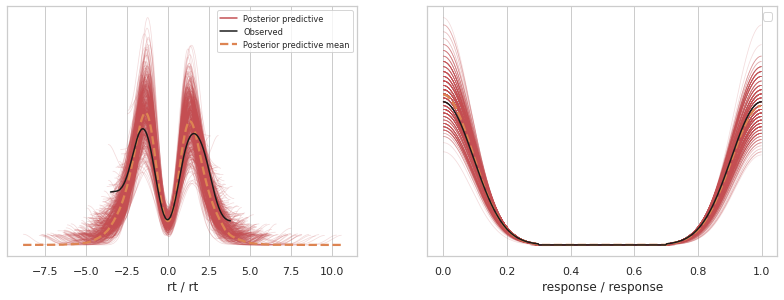

In [35]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "HC") & (data.dbs==0)].index
plot_infData = InfData['ms7'].isel(trial_idx=plot_index)
az.plot_ppc(plot_infData, num_pp_samples=500, random_seed=7, color="r") # 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcef8102bd0>,
      dtype=object)

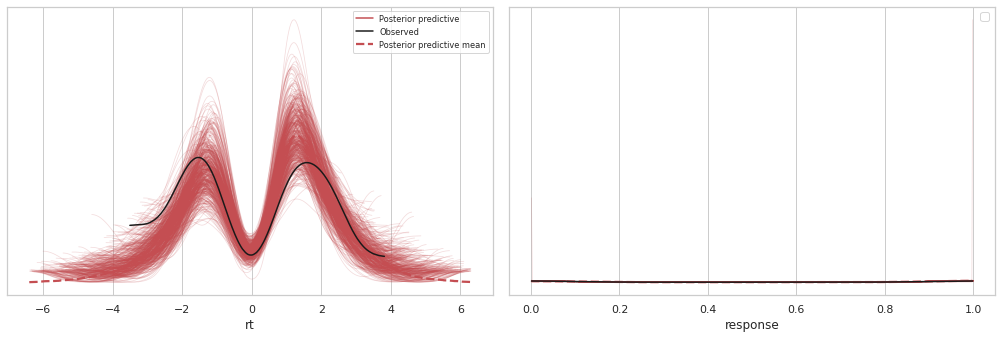

In [77]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "HC") & (data.dbs==0)].index
plot_infData = InfData['ms0'].isel(trial_idx=plot_index)
az.plot_ppc(plot_infData, num_pp_samples=500, random_seed=7, color="r") # 

/opt/conda/lib/python3.7/site-packages/arviz/plots/ppcplot.py:225: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e3d7be310>,
      dtype=object)

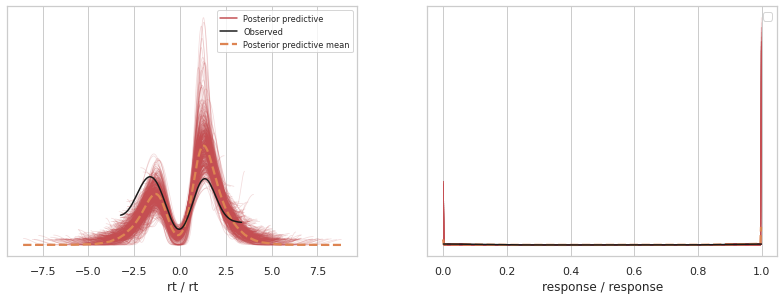

In [36]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "LC") & (data.dbs==1)].index
plot_infData = InfData['ms7'].isel(trial_idx=plot_index)
az.plot_ppc(plot_infData, num_pp_samples=500, random_seed=7, color="r") # 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf37ad9e10>,
      dtype=object)

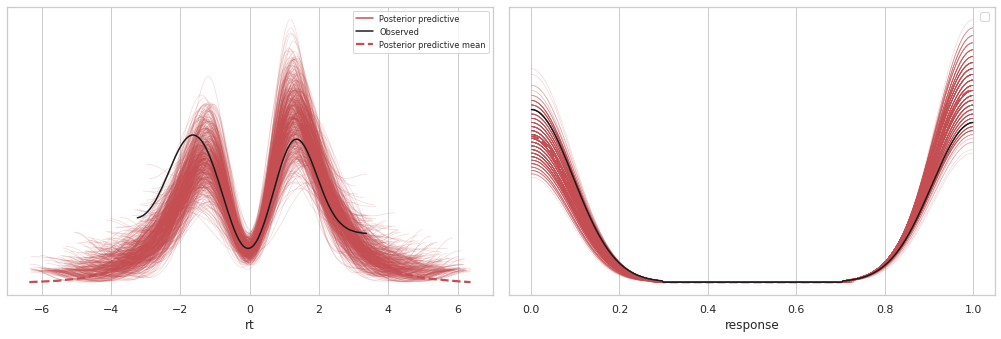

In [76]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "LC") & (data.dbs==1)].index
plot_infData = InfData['ms0'].isel(trial_idx=plot_index)
az.plot_ppc(plot_infData, num_pp_samples=500, random_seed=7, color="r") # 

/opt/conda/lib/python3.7/site-packages/arviz/plots/ppcplot.py:225: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e370bee90>,
      dtype=object)

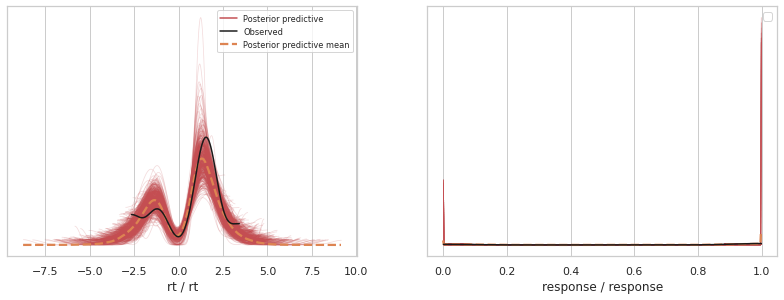

In [37]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "LC") & (data.dbs==0)].index
plot_infData = InfData['ms7'].isel(trial_idx=plot_index)
az.plot_ppc(plot_infData, kind="kde", num_pp_samples=500, random_seed=7, color="r") # 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf387c21d0>,
      dtype=object)

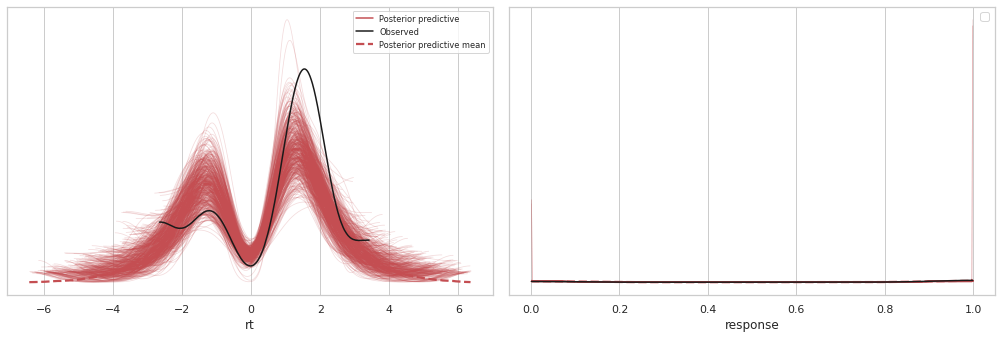

In [75]:
plot_index = data[(data.subj_idx == 0) & (data.conf == "LC") & (data.dbs==0)].index
plot_infData = InfData['ms0'].isel(trial_idx=plot_index)
az.plot_ppc(plot_infData, kind="kde", num_pp_samples=500, random_seed=7, color="r") # 

In [68]:
# below are the default value of parameters of plot_ppc
kind="kde"
alpha=None
mean=True
observed=True
color=None
colors=None
grid=None
figsize=None
textsize=None
data_pairs=None
var_names=None
filter_vars=None
coords=None
flatten=None
flatten_pp=None
num_pp_samples=None
random_seed=None
jitter=None
animated=False
animation_kwargs=None
legend=True
labeller=None
ax=None
backend=None
backend_kwargs=None
group="posterior"
show=None

backend = rcParams["plot.backend"]
backend = backend.lower()

# ppcplot_kwargs = dict(
#     ax=ax,
#     length_plotters=length_plotters,
#     rows=rows,
#     cols=cols,
#     figsize=figsize,
#     animated=animated,
#     obs_plotters=obs_plotters,
#     pp_plotters=pp_plotters,
#     predictive_dataset=predictive_dataset,
#     pp_sample_ix=pp_sample_ix,
#     kind=kind,
#     alpha=alpha,
#     #colors=colors,
#     jitter=jitter,
#     textsize=textsize,
#     mean=mean,
#     observed=observed,
#     total_pp_samples=total_pp_samples,
#     legend=legend,
#     #labeller=labeller,
#     group=group,
#     animation_kwargs=animation_kwargs,
#     num_pp_samples=num_pp_samples,
#     backend_kwargs=backend_kwargs,
#     show=show,
# )

In [335]:
print(az.__file__)

/opt/conda/lib/python3.7/site-packages/arviz/__init__.py


In [379]:
subjects = [6, 3]
cond = {'conf': ['HC', 'LC', 'HC', 'LC'],
        'dbs': [0, 0, 1, 1]}

or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

var_names = ['rt']

obs_plotters = []
pp_plotters = []
for subj_idx in subjects:
    if cond is not None:
        
        for conf_idx, dbs_idx in zip(cond['conf'], cond['dbs']):
            plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d.conf == conf_idx) & (data.dbs==dbs_idx)].index
            data_tmp = InfData['ms7'].isel(trial_idx=plot_idx)
            
            observed_data_tmp = data_tmp.observed_data
            predictive_data_tmp = data_tmp.posterior_predictive

            if var_names is None:
                var_names = list(observed_data.data_vars)
            var_names = _var_names(var_names, observed_data, filter_vars)
            pp_var_names = [data_pairs.get(var, var) for var in var_names]
            pp_var_names = _var_names(pp_var_names, predictive_dataset, filter_vars)

            if flatten_pp is None and flatten is None:
                flatten_pp = list(predictive_dataset.dims.keys())
            elif flatten_pp is None:
                flatten_pp = flatten
            if flatten is None:
                flatten = list(observed_data.dims.keys())

            if coords is None:
                coords = {}

            if labeller is None:
                labeller = BaseLabeller()

            if random_seed is not None:
                np.random.seed(random_seed)

            total_pp_samples = predictive_dataset.sizes["chain"] * predictive_dataset.sizes["draw"]

            pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

            for key in coords.keys():
                coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]

            obs_plotters_tmp = filter_plotters_list(
                list(
                    xarray_var_iter(
                        observed_data_tmp.isel(coords),
                        skip_dims=set(flatten),
                        var_names=var_names,
                        combined=True,
                    )
                ),
                "plot_ppc",
            )
            
            length_plotters_tmp = len(obs_plotters_tmp)
            pp_plotters_tmp = [
                tup
                for _, tup in zip(
                    range(length_plotters_tmp),
                    xarray_var_iter(
                        predictive_data_tmp.isel(coords),
                        var_names=pp_var_names,
                        skip_dims=set(flatten_pp),
                        combined=True,
                    ),
                )
            ]
            for ls_idx in range(len(var_names)):
                tmp0 = list(obs_plotters_tmp[0])
                tmp0[1]['subj_idx'] = "subj_" + str(subj_idx)
                tmp0[1]['conf'] = conf_idx
                tmp0[1]['dbs'] = "dbs_" + str(dbs_idx)
                tmp0[2]['subj_idx'] = "subj_" + str(subj_idx)
                tmp0[2]['conf'] = conf_idx
                tmp0[2]['dbs'] = "dbs_" + str(dbs_idx)

                tmp1 = list(pp_plotters_tmp[0])
                tmp1[1]['subj_idx'] = "subj_" + str(subj_idx)
                tmp1[1]['conf'] = conf_idx
                tmp1[1]['dbs'] = "dbs_" + str(dbs_idx)
                tmp1[2]['subj_idx'] = "subj_" + str(subj_idx)
                tmp1[2]['conf'] = conf_idx
                tmp1[2]['dbs'] = "dbs_" + str(dbs_idx)

    #             pp_plotters = []
    #             pp_plotters.append(tuple(tmp0))
    #             pp_plotters.append(tuple(tmp1))

    #             pp_plotters

                obs_plotters.append(tuple(tmp0))
                pp_plotters.append(tuple(tmp1))
length_plotters = len(obs_plotters)
rows, cols = default_grid(length_plotters, grid=grid)

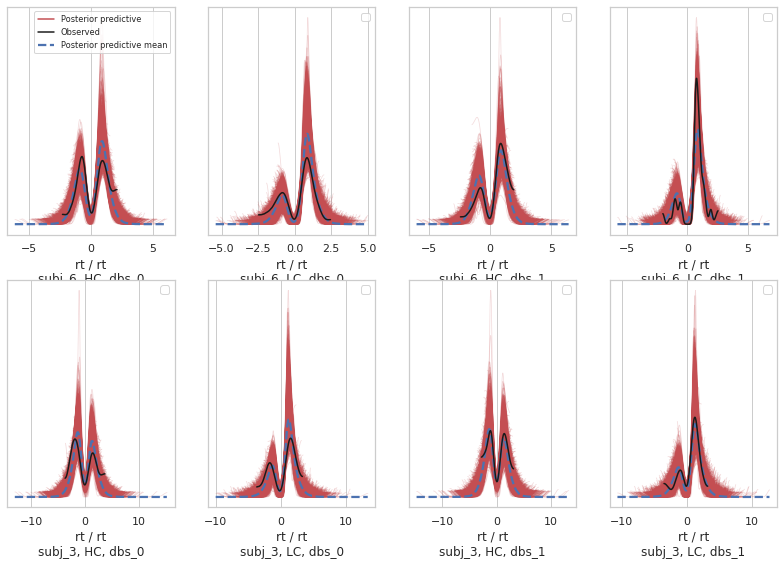

In [380]:
ppcplot_kwargs = dict(
    ax=ax,
    length_plotters=length_plotters,
    rows=rows,
    cols=cols,
    figsize=figsize,
    animated=animated,
    obs_plotters=obs_plotters,
    pp_plotters=pp_plotters,
    predictive_dataset=predictive_dataset,
    pp_sample_ix=pp_sample_ix,
    kind=kind,
    alpha=alpha,
    colors=colors,
    jitter=jitter,
    textsize=textsize,
    mean=mean,
    observed=observed,
    total_pp_samples=total_pp_samples,
    legend=legend,
    labeller=labeller,
    group=group,
    animation_kwargs=animation_kwargs,
    num_pp_samples=num_pp_samples,
    backend_kwargs=backend_kwargs,
    show=show,
)

plot = get_plotting_function("plot_ppc", "ppcplot", backend)
axes = plot(**ppcplot_kwargs)

In [243]:
plot_index0 = data[(data.subj_idx == 0) & (data.conf == "HC") & (data.dbs==1)].index
plot_index1 = data[(data.subj_idx == 0) & (data.conf == "LC") & (data.dbs==1)].index
data_tmp0 = InfData['ms7'].isel(trial_idx=plot_index0)
data_tmp1 = InfData['ms7'].isel(trial_idx=plot_index1)

observed_data_tmp0 = data_tmp0.observed_data
observed_data_tmp1 = data_tmp1.observed_data

predictive_data_tmp0 = data_tmp0.posterior_predictive
predictive_data_tmp1 = data_tmp1.posterior_predictive


In [244]:
observed_data_tmp0

<xarray.Dataset>
Dimensions:    (trial_idx: 73)
Coordinates:
  * trial_idx  (trial_idx) int64 0 2 4 6 8 10 12 ... 138 139 140 144 146 148 149
Data variables:
    rt         (trial_idx) float64 1.21 1.03 -1.14 2.0 ... 1.75 1.15 -1.14 2.34
    response   (trial_idx) float64 1.0 1.0 0.0 1.0 1.0 ... 0.0 1.0 1.0 0.0 1.0

In [116]:
observed_data_tmp1

<xarray.Dataset>
Dimensions:    (trial_idx: 77)
Coordinates:
  * trial_idx  (trial_idx) int64 1 3 5 7 9 11 14 ... 135 136 141 142 143 145 147
Data variables:
    rt         (trial_idx) float64 1.63 2.77 1.15 -1.04 ... 1.25 -1.6 1.36 -2.2
    response   (trial_idx) float64 1.0 1.0 1.0 0.0 0.0 ... 0.0 1.0 0.0 1.0 0.0

In [117]:
predictive_data_tmp0

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, trial_idx: 73)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * trial_idx  (trial_idx) int64 0 2 4 6 8 10 12 ... 138 139 140 144 146 148 149
Data variables:
    rt         (chain, draw, trial_idx) float64 -3.823 1.494 ... -1.131 -1.011
    response   (chain, draw, trial_idx) float64 0.0 1.0 0.0 1.0 ... 1.0 0.0 0.0

In [118]:
predictive_data_tmp1

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, trial_idx: 77)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * trial_idx  (trial_idx) int64 1 3 5 7 9 11 14 ... 135 136 141 142 143 145 147
Data variables:
    rt         (chain, draw, trial_idx) float64 1.484 1.574 ... -0.9986 -1.129
    response   (chain, draw, trial_idx) float64 1.0 1.0 0.0 1.0 ... 0.0 0.0 0.0

In [245]:
# observed_data_tmp1 = InfData['ms7'].observed_data
# predictive_dataset = InfData['ms7'].posterior_predictive
var_names = list(observed_data_tmp0.data_vars)
var_names

['rt', 'response']

In [246]:
data_pairs = {}
filter_vars=None
var_names = _var_names(var_names, observed_data_tmp0, filter_vars)
pp_var_names = [data_pairs.get(var, var) for var in var_names]
pp_var_names = _var_names(pp_var_names, predictive_data_tmp1, filter_vars)
pp_var_names

['rt', 'response']

In [247]:
flatten_pp = list(predictive_data_tmp1.dims.keys())
flatten_pp

['chain', 'draw', 'trial_idx']

In [248]:
flatten = list(observed_data_tmp0.dims.keys())
flatten

['trial_idx']

In [249]:
if coords is None:
    coords = {}
print(coords)
if labeller is None:
    labeller = BaseLabeller()

if random_seed is not None:
    np.random.seed(random_seed)
    


{}


In [124]:
total_pp_samples = predictive_data_tmp1.sizes["chain"] * predictive_data_tmp1.sizes["draw"]
total_pp_samples

num_pp_samples = total_pp_samples
num_pp_samples

4000

In [125]:
pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)
pp_sample_ix

array([1269, 1625, 2384, ..., 2524, 2582, 2728])

In [127]:
coords = {}
for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data_tmp0[key], coords[key]))[0]
coords

{}

Here, `xarray_var_iter()` is used to select the data for plotting, `xarray_var_iter()` in turn used `xarray_sel_iter()` to select the data.

Input of `xarray_sel_iter()` are `inferencedata`, `var_names`, `combine`, `skip_dims`. The `skip_dims` are those in the observed dimensions.


By using this function, the variable name and its data will be selected, and `yield` a tuple which contain the variable name, two empty dict and a "numpy.ndarray" for observed_data.

For posterior_predicitves, it will yield a tuple which contain the variable name, two empty dict and a "numpy.ndarray" with a length of 4, each contain 1000 data points, represents samples from 4 chains.

The returned list (which includes "rt" and "repsonse") in HDDM case will be used as input of plotter.

`obs_plotters`: A list of 2 elements, a tuple, corresponding to number of `var_names`. In our cases, it has two tuples, one for RT, one for response. In the first tuple, it has 4 elements: var_name, two empty dict (one for `selection`, one for `isel`), and one np.ndarray (with length of selected obs).

`selection`, `isel`, are used for labelling in plotting (arviz/plots/backends/matplotlib/ppcplot.py L358) `labeller.make_pp_label(var_name, pp_var_name, selection, isel), fontsize=ax_labelsize)`. After teseting, I found that only when both `selection` and `isel` are filled, there will it will be added at x-axis in the plot.

```
def make_pp_label(self, var_name, pp_var_name, sel, isel):
    """WIP."""
    names = self.var_pp_to_str(var_name, pp_var_name)
    return self.make_label_vert(names, sel, isel)
```

`pp_plotters`: A list of 2 elements two, a tuple, corresponding to number of `var_names`. In our cases, it has two tuples, one for RT, one for response. In the first tuple, it has 4 elements: var_name, two empty dict, and one np.ndarray (with length of **chains**). In the forth elements of the two tuples, it contain four chains of data of the Posterior predictives. 

**Can we hack it here, include longer list?**

In [128]:
data_to_sel = observed_data_tmp0.isel(coords)
data_to_sel

<xarray.Dataset>
Dimensions:    (trial_idx: 73)
Coordinates:
  * trial_idx  (trial_idx) int64 0 2 4 6 8 10 12 ... 138 139 140 144 146 148 149
Data variables:
    rt         (trial_idx) float64 1.21 1.03 -1.14 2.0 ... 1.75 1.15 -1.14 2.34
    response   (trial_idx) float64 1.0 1.0 0.0 1.0 1.0 ... 0.0 1.0 1.0 0.0 1.0

In [129]:
var_names is None 

False

In [130]:
isinstance(observed_data.isel(coords), xr.DataArray)

False

In [131]:
if var_names is None and isinstance(observed_data_tmp0.isel(coords), xr.DataArray):
    data_to_sel = {data.name: data}

In [250]:
data_to_sel

<xarray.Dataset>
Dimensions:    (trial_idx: 73)
Coordinates:
  * trial_idx  (trial_idx) int64 0 2 4 6 8 10 12 ... 138 139 140 144 146 148 149
Data variables:
    rt         (trial_idx) float64 1.21 1.03 -1.14 2.0 ... 1.75 1.15 -1.14 2.34
    response   (trial_idx) float64 1.0 1.0 0.0 1.0 1.0 ... 0.0 1.0 1.0 0.0 1.0

In [133]:
type(flatten)

list

In [134]:
reverse_selections=False
data = observed_data.isel(coords)
var_names=var_names
combined=True
skip_dims=set(flatten)
reverse_selections=reverse_selections

In [135]:
print(var_names)

['rt', 'response']


In [136]:
type(skip_dims)

set

In [137]:
if skip_dims is None:
    skip_dims = set()

if combined:
    skip_dims = skip_dims.union({"chain", "draw"})
else:
    skip_dims.add("draw")

if var_names is None:
    if isinstance(data, xr.Dataset):
        var_names = list(data.data_vars)
    elif isinstance(data, xr.DataArray):
        var_names = [data.name]
        data = {data.name: data}
var_names

['rt', 'response']

In [138]:
skip_dims

{'chain', 'draw', 'trial_idx'}

In [139]:
def _dims(data, var_name, skip_dims):
    return [dim for dim in data[var_name].dims if dim not in skip_dims]

def _zip_dims(new_dims, vals):
    return [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]

for var_name in var_names:
    print(var_name)
    if var_name in data:
        new_dims = _dims(data, var_name, skip_dims)
        print(new_dims)
        vals = [purge_duplicates(data[var_name][dim].values) for dim in new_dims]
        print(vals)
        dims = _zip_dims(new_dims, vals)
        print(dims)
        idims = _zip_dims(new_dims, [range(len(v)) for v in vals])
        if reverse_selections:
            dims = reversed(dims)
            print(dims)
            idims = reversed(idims)

        for selection, iselection in zip(dims, idims):
            print([var_name, selection, iselection])

rt
[]
[]
[{}]
['rt', {}, {}]
response
[]
[]
[{}]
['response', {}, {}]


In [140]:
for dim in data[var_name].dims:
    if dim not in skip_dims:
        print(dim)

In [141]:
tmp = xarray_var_iter(
            observed_data.isel(coords),
            skip_dims=set(flatten),
            var_names=var_names,
            combined=True,
        )

In [142]:
tmp_list = list(tmp)
tmp_list

[('rt', {}, {}, array([ 1.21 ,  1.63 ,  1.03 , ...,  0.784, -2.35 ,  1.25 ])),
 ('response', {}, {}, array([1., 1., 1., ..., 1., 0., 1.]))]

In [279]:
obs_plotters0 = filter_plotters_list(
    list(
        xarray_var_iter(
            observed_data_tmp0.isel(coords),
            skip_dims=set(flatten),
            var_names=var_names,
            combined=True,
        )
    ),
    "plot_ppc",
)

obs_plotters0

[('rt',
  {},
  {},
  array([ 1.21 ,  1.03 , -1.14 ,  2.   ,  0.857,  1.72 ,  1.72 ,  1.72 ,
         -2.44 , -0.987,  2.38 , -1.17 , -1.88 ,  0.972, -2.84 ,  2.3  ,
          2.35 ,  1.7  ,  1.46 ,  1.96 ,  2.76 , -2.15 , -3.15 , -1.38 ,
         -1.38 ,  3.17 ,  0.946, -3.83 ,  1.2  ,  1.2  , -1.49 , -1.56 ,
          0.886, -1.84 ,  0.968,  0.841, -1.96 , -2.35 , -2.87 , -3.23 ,
         -3.66 , -1.98 , -0.602,  0.947, -1.25 ,  0.95 , -2.17 , -1.98 ,
         -1.1  ,  2.2  , -2.72 , -1.04 , -1.93 ,  1.95 ,  1.5  , -1.87 ,
         -1.65 ,  1.56 ,  1.15 ,  3.86 ,  0.814,  1.08 ,  2.03 , -1.59 ,
          1.63 , -1.95 ,  2.02 ,  1.36 , -2.07 ,  1.75 ,  1.15 , -1.14 ,
          2.34 ])),
 ('response',
  {},
  {},
  array([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 1., 0., 0., 1., 1., 1., 1

In [315]:
tmp0 = list(obs_plotters0[0])
tmp0[1]['subj_idx'] = "Subj_0"
tmp0[1]['conf'] = "HC"
tmp0[2]['subj_idx'] = "Subj_0"
tmp0[2]['conf'] = "HC"
# tmp0[0] = 'subj0_HC_' + tmp0[0]
# obs_plotters0[0] = tmp[0]
tmp1 = list(obs_plotters0[1])
tmp1[1]['subj_idx'] = "Subj_0"
tmp1[1]['conf'] = "HC"
tmp1[2]['subj_idx'] = "Subj_0"
tmp1[2]['conf'] = "HC"
#tmp1[0] = 'subj0_HC_' + tmp1[0]

obs_plotters = []
obs_plotters.append(tuple(tmp0))
obs_plotters.append(tuple(tmp1))

obs_plotters

[('rt',
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  array([ 1.21 ,  1.03 , -1.14 ,  2.   ,  0.857,  1.72 ,  1.72 ,  1.72 ,
         -2.44 , -0.987,  2.38 , -1.17 , -1.88 ,  0.972, -2.84 ,  2.3  ,
          2.35 ,  1.7  ,  1.46 ,  1.96 ,  2.76 , -2.15 , -3.15 , -1.38 ,
         -1.38 ,  3.17 ,  0.946, -3.83 ,  1.2  ,  1.2  , -1.49 , -1.56 ,
          0.886, -1.84 ,  0.968,  0.841, -1.96 , -2.35 , -2.87 , -3.23 ,
         -3.66 , -1.98 , -0.602,  0.947, -1.25 ,  0.95 , -2.17 , -1.98 ,
         -1.1  ,  2.2  , -2.72 , -1.04 , -1.93 ,  1.95 ,  1.5  , -1.87 ,
         -1.65 ,  1.56 ,  1.15 ,  3.86 ,  0.814,  1.08 ,  2.03 , -1.59 ,
          1.63 , -1.95 ,  2.02 ,  1.36 , -2.07 ,  1.75 ,  1.15 , -1.14 ,
          2.34 ])),
 ('response',
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  array([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,

In [301]:
obs_plotters1 = filter_plotters_list(
    list(
        xarray_var_iter(
            observed_data_tmp1.isel(coords),
            skip_dims=set(flatten),
            var_names=var_names,
            combined=True,
        )
    ),
    "plot_ppc",
)

obs_plotters1

[('rt',
  {},
  {},
  array([ 1.63 ,  2.77 ,  1.15 , -1.04 , -1.5  , -0.656,  1.36 , -1.57 ,
         -2.36 ,  1.38 ,  1.01 , -1.01 , -1.51 ,  1.05 , -3.25 ,  1.53 ,
         -1.6  ,  2.74 ,  1.53 ,  0.661,  2.17 ,  0.782, -3.21 ,  1.91 ,
          1.48 ,  1.35 ,  1.54 ,  2.24 , -2.23 , -2.5  ,  1.65 , -1.59 ,
         -1.94 , -1.83 , -0.714,  0.632, -2.28 , -1.98 , -1.89 , -2.08 ,
         -0.907,  2.19 , -1.41 , -1.16 , -0.947, -1.05 , -1.61 , -1.92 ,
          1.47 ,  0.87 ,  0.746,  1.63 ,  3.37 ,  1.13 , -2.03 ,  1.45 ,
         -0.965,  2.78 , -0.994,  1.13 ,  1.11 , -1.66 , -1.37 , -1.65 ,
         -2.63 ,  2.52 ,  0.833,  3.36 , -1.24 , -2.7  ,  1.73 , -2.86 ,
         -2.19 ,  1.25 , -1.6  ,  1.36 , -2.2  ])),
 ('response',
  {},
  {},
  array([1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1

In [316]:
tmp2 = list(obs_plotters1[0])
tmp2[1]['subj_idx'] = "Subj_0"
tmp2[1]['conf'] = "LC"
tmp2[2]['subj_idx'] = "Subj_0"
tmp2[2]['conf'] = "LC"
# tmp2[0] = 'subj0_LC_' + tmp2[0]
# obs_plotters0[0] = tmp[0]
tmp3 = list(obs_plotters1[1])
tmp3[1]['subj_idx'] = "Subj_0"
tmp3[1]['conf'] = "LC"
tmp3[2]['subj_idx'] = "Subj_0"
tmp3[2]['conf'] = "LC"
# tmp3[0] = 'subj0_LC_' + tmp3[0]

obs_plotters.append(tuple(tmp2))
obs_plotters.append(tuple(tmp3))
# obs_plotters[2] = tuple(tmp2)
# obs_plotters[3] = tuple(tmp3)

obs_plotters

[('rt',
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  array([ 1.21 ,  1.03 , -1.14 ,  2.   ,  0.857,  1.72 ,  1.72 ,  1.72 ,
         -2.44 , -0.987,  2.38 , -1.17 , -1.88 ,  0.972, -2.84 ,  2.3  ,
          2.35 ,  1.7  ,  1.46 ,  1.96 ,  2.76 , -2.15 , -3.15 , -1.38 ,
         -1.38 ,  3.17 ,  0.946, -3.83 ,  1.2  ,  1.2  , -1.49 , -1.56 ,
          0.886, -1.84 ,  0.968,  0.841, -1.96 , -2.35 , -2.87 , -3.23 ,
         -3.66 , -1.98 , -0.602,  0.947, -1.25 ,  0.95 , -2.17 , -1.98 ,
         -1.1  ,  2.2  , -2.72 , -1.04 , -1.93 ,  1.95 ,  1.5  , -1.87 ,
         -1.65 ,  1.56 ,  1.15 ,  3.86 ,  0.814,  1.08 ,  2.03 , -1.59 ,
          1.63 , -1.95 ,  2.02 ,  1.36 , -2.07 ,  1.75 ,  1.15 , -1.14 ,
          2.34 ])),
 ('response',
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  array([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,

In [283]:
pp_plotters0 = [
    tup
    for _, tup in zip(
        range(length_plotters),
        xarray_var_iter(
            predictive_data_tmp0.isel(coords),
            var_names=pp_var_names,
            skip_dims=set(flatten_pp),
            combined=True,
        ),
    )
]
# print(length_plotters)
pp_plotters0

[('rt',
  {},
  {},
  array([[[-3.82283542,  1.49434139, -1.57898587, ..., -1.398955  ,
           -1.44385706, -0.99055113],
          [-2.12128315,  1.16686022, -1.26058812, ...,  1.33296851,
            1.20857451,  2.75555919],
          [ 2.12832162,  1.64529016,  1.67490756, ...,  1.59976289,
            1.75015385,  1.52606476],
          ...,
          [-1.3837376 , -1.66641283,  1.21008088, ...,  2.67436288,
           -2.35344212,  1.60947511],
          [ 3.16176606,  1.32616984,  2.05014697, ...,  1.57013259,
            3.2826022 , -1.04357159],
          [ 1.02874084,  1.26341332,  2.12180841, ..., -1.47207685,
            5.15091573, -1.2110603 ]],
  
         [[ 2.5584844 ,  1.18432221, -2.68369288, ...,  1.16382141,
            2.01203696,  1.5068893 ],
          [-1.23400722, -0.93078506, -1.73089772, ...,  1.99228863,
            4.01743345, -1.64744543],
          [-1.57835561,  1.06881492, -1.27919304, ...,  1.82078637,
           -2.12170673, -1.1303828 ],
       

In [303]:
tmp0 = list(pp_plotters0[0])
tmp0[1]['subj_idx'] = 'Subj_0'
tmp0[1]['conf'] = "HC"
tmp0[2]['subj_idx'] = 'Subj_0'
tmp0[2]['conf'] = "HC"
# tmp0[0] = 'subj0_HC_' + tmp0[0]
# obs_plotters0[0] = tmp[0]
tmp1 = list(pp_plotters0[1])
# tmp1[0] = 'subj0_HC_' + tmp1[0]
tmp1[1]['subj_idx'] = 'Subj_0'
tmp1[1]['conf'] = "HC"
tmp1[2]['subj_idx'] = 'Subj_0'
tmp1[2]['conf'] = "HC"

pp_plotters = []
pp_plotters.append(tuple(tmp0))
pp_plotters.append(tuple(tmp1))

pp_plotters

[('rt',
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  array([[[-3.82283542,  1.49434139, -1.57898587, ..., -1.398955  ,
           -1.44385706, -0.99055113],
          [-2.12128315,  1.16686022, -1.26058812, ...,  1.33296851,
            1.20857451,  2.75555919],
          [ 2.12832162,  1.64529016,  1.67490756, ...,  1.59976289,
            1.75015385,  1.52606476],
          ...,
          [-1.3837376 , -1.66641283,  1.21008088, ...,  2.67436288,
           -2.35344212,  1.60947511],
          [ 3.16176606,  1.32616984,  2.05014697, ...,  1.57013259,
            3.2826022 , -1.04357159],
          [ 1.02874084,  1.26341332,  2.12180841, ..., -1.47207685,
            5.15091573, -1.2110603 ]],
  
         [[ 2.5584844 ,  1.18432221, -2.68369288, ...,  1.16382141,
            2.01203696,  1.5068893 ],
          [-1.23400722, -0.93078506, -1.73089772, ...,  1.99228863,
            4.01743345, -1.64744543],
          [-1.57835561,  1.06881492, -1.27919

In [285]:
pp_plotters1 = [
    tup
    for _, tup in zip(
        range(length_plotters),
        xarray_var_iter(
            predictive_data_tmp1.isel(coords),
            var_names=pp_var_names,
            skip_dims=set(flatten_pp),
            combined=True,
        ),
    )
]
# print(length_plotters)
pp_plotters1

[('rt',
  {},
  {},
  array([[[ 1.48361254,  1.57362892, -1.75236699, ...,  3.64287934,
           -0.9549658 ,  2.21364171],
          [ 1.56989023, -2.07796498,  4.40930415, ..., -1.65189852,
           -1.92367715, -1.84422415],
          [ 1.5645146 , -1.14247158,  0.97266263, ...,  1.06801178,
            0.81432273,  1.89953703],
          ...,
          [-2.34244127,  1.17029974, -1.37467116, ...,  1.53792363,
           -1.13389763,  2.95004234],
          [ 3.76104091, -1.04120644,  1.97127386, ...,  1.1602049 ,
           -0.97780858,  1.35325491],
          [ 1.10295848, -1.35614765,  3.66474105, ...,  1.01589319,
            1.28882494,  2.19597779]],
  
         [[-2.19345862,  1.15591142,  2.1303559 , ...,  1.32910478,
            0.74976075, -1.81804913],
          [ 1.36286823,  1.06579416,  2.12865899, ...,  1.45347238,
            1.58723072, -2.24188492],
          [-1.37243386, -0.85247328,  2.01186419, ...,  1.19297757,
            1.29301648, -2.73981986],
       

In [304]:
tmp2 = list(pp_plotters1[0])
tmp2[1]['subj_idx'] = 'Subj_0'
tmp2[1]['conf'] = "LC"
tmp2[2]['subj_idx'] = 'Subj_0'
tmp2[2]['conf'] = "LC"

# tmp2[0] = 'subj0_LC_' + tmp2[0]
# obs_plotters0[0] = tmp[0]
tmp3 = list(pp_plotters1[1])
tmp3[1]['subj_idx'] = 'Subj_0'
tmp3[1]['conf'] = "LC"
tmp3[2]['subj_idx'] = 'Subj_0'
tmp3[2]['conf'] = "LC"
# tmp3[0] = 'subj0_LC_' + tmp3[0]

pp_plotters.append(tuple(tmp2))
pp_plotters.append(tuple(tmp3))

pp_plotters

[('rt',
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  {'subj_idx': 'Subj_0', 'conf': 'HC'},
  array([[[-3.82283542,  1.49434139, -1.57898587, ..., -1.398955  ,
           -1.44385706, -0.99055113],
          [-2.12128315,  1.16686022, -1.26058812, ...,  1.33296851,
            1.20857451,  2.75555919],
          [ 2.12832162,  1.64529016,  1.67490756, ...,  1.59976289,
            1.75015385,  1.52606476],
          ...,
          [-1.3837376 , -1.66641283,  1.21008088, ...,  2.67436288,
           -2.35344212,  1.60947511],
          [ 3.16176606,  1.32616984,  2.05014697, ...,  1.57013259,
            3.2826022 , -1.04357159],
          [ 1.02874084,  1.26341332,  2.12180841, ..., -1.47207685,
            5.15091573, -1.2110603 ]],
  
         [[ 2.5584844 ,  1.18432221, -2.68369288, ...,  1.16382141,
            2.01203696,  1.5068893 ],
          [-1.23400722, -0.93078506, -1.73089772, ...,  1.99228863,
            4.01743345, -1.64744543],
          [-1.57835561,  1.06881492, -1.27919

In [306]:
length_plotters = len(pp_plotters)
length_plotters

4

In [317]:
predictive_dataset

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, trial_idx: 3988)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * trial_idx  (trial_idx) int64 0 1 2 3 4 5 6 ... 3982 3983 3984 3985 3986 3987
Data variables:
    rt         (chain, draw, trial_idx) float64 -3.823 1.484 ... -0.7744 -1.271
    response   (chain, draw, trial_idx) float64 0.0 1.0 1.0 1.0 ... 1.0 0.0 0.0

In [308]:
dtype = predictive_dataset['response'].dtype.kind
dtype

'f'

In [319]:
type(predictive_dataset['response'])

xarray.core.dataarray.DataArray

In [325]:
predictive_dataset['response'] = predictive_dataset['response'].astype(float)
predictive_dataset['response'].dtype.kind

'f'

In [326]:
rows, cols = default_grid(length_plotters, grid=(2,2))

In [327]:
rows

2

In [328]:
cols

2

In [329]:
ppcplot_kwargs = dict(
    ax=None,
    length_plotters=length_plotters,
    rows=rows,
    cols=cols,
    figsize=figsize,
    animated=animated,
    obs_plotters=obs_plotters,
    pp_plotters=pp_plotters,
    predictive_dataset=predictive_dataset,
    pp_sample_ix=pp_sample_ix,
    kind=kind,
    alpha=alpha,
    colors=['r', 'k', 'b'],
    jitter=jitter,
    textsize=textsize,
    mean=mean,
    observed=observed,
    total_pp_samples=total_pp_samples,
    legend=legend,
    labeller=labeller,
    group=group,
    animation_kwargs=animation_kwargs,
    num_pp_samples=num_pp_samples,
    backend_kwargs=backend_kwargs,
    show=show,
)

In [323]:
plot = get_plotting_function("plot_ppc", "ppcplot", backend)

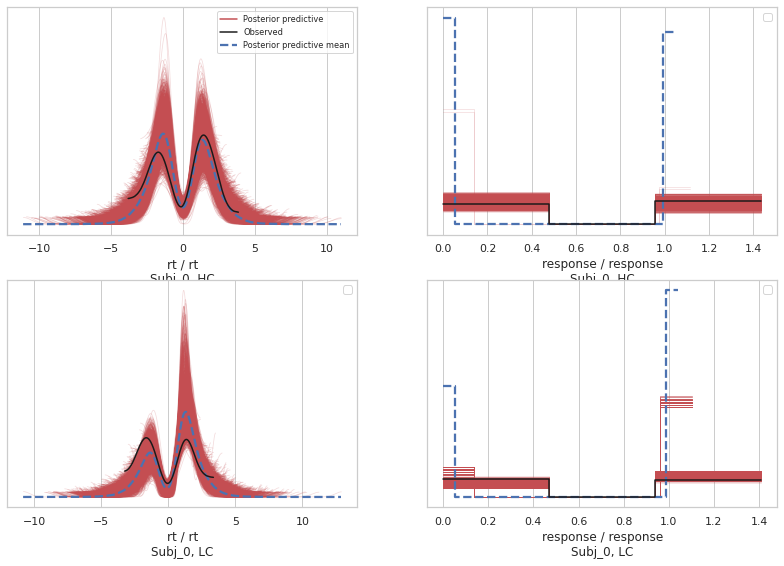

In [324]:
axes = plot(**ppcplot_kwargs)

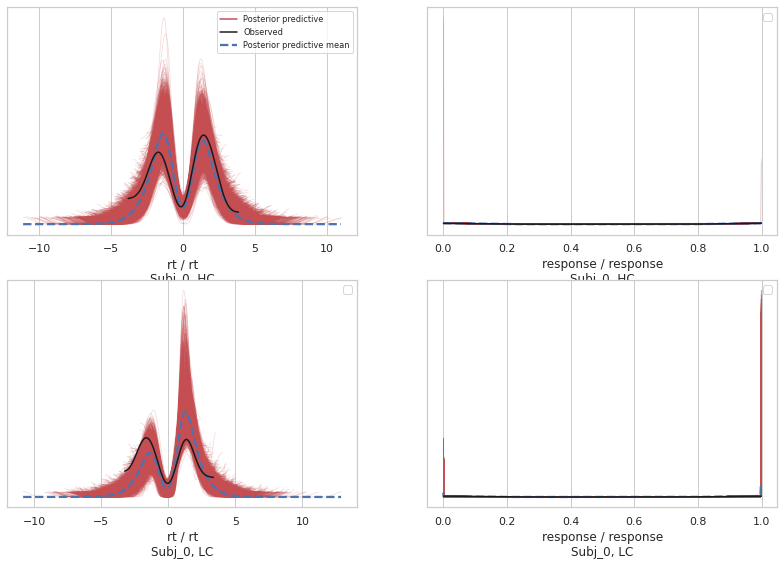

In [330]:
plot = get_plotting_function("plot_ppc", "ppcplot", backend)
axes = plot(**ppcplot_kwargs)

In [291]:
var_name = 'rt'
pp_var_name = 'rt'

In [298]:
selection_tmp =  {'subj_idx': 'Subj_0', 'conf': 'HC'}
isel_tmp = {'subj_idx': 'Subj_0', 'conf': 'HC'}

In [299]:
labeller.make_pp_label(var_name, pp_var_name, selection_tmp, isel_tmp)

'rt / rt\nSubj_0, HC'

In [240]:
colors=['r', 'k', 'b']
# linewidth = 1
for i, ax_i in enumerate(np.ravel(axes)[:length_plotters]):
    var_name, selection, isel, obs_vals = obs_plotters[i]
    pp_var_name, _, _, pp_vals = pp_plotters[i]
    dtype = 'f'
#         dtype = predictive_dataset[pp_var_name].dtype.kind

#         if dtype not in ["i", "f"]:
#             raise ValueError(
#                 f"The data type of the predictive data must be one of 'i' or 'f', but is '{dtype}'"
#             )

    # flatten non-specified dimensions
    obs_vals = obs_vals.flatten()
    pp_vals = pp_vals.reshape(total_pp_samples, -1)
    pp_sampled_vals = pp_vals[pp_sample_ix]

    if kind == "kde":
        plot_kwargs = {"color": colors[0], "alpha": alpha, "linewidth": 0.5 * linewidth}
        if dtype == "i":
            plot_kwargs["drawstyle"] = "steps-pre"
        ax_i.plot([], color=colors[0], label=f"{group.capitalize()} predictive")
        if observed:
            if dtype == "f":
                plot_kde(
                    obs_vals,
                    label="Observed",
                    plot_kwargs={"color": colors[1], "linewidth": linewidth, "zorder": 3},
                    fill_kwargs={"alpha": 0},
                    ax=ax_i,
                    legend=legend,
                )
            else:
                bins = get_bins(obs_vals)
                _, hist, bin_edges = histogram(obs_vals, bins=bins)
                hist = np.concatenate((hist[:1], hist))
                ax_i.plot(
                    bin_edges,
                    hist,
                    label="Observed",
                    color=colors[1],
                    linewidth=linewidth,
                    zorder=3,
                    drawstyle=plot_kwargs["drawstyle"],
                )

        pp_densities = []
        pp_xs = []
        for vals in pp_sampled_vals:
            vals = np.array([vals]).flatten()
            if dtype == "f":
                pp_x, pp_density = kde(vals)
                pp_densities.append(pp_density)
                pp_xs.append(pp_x)
            else:
                bins = get_bins(vals)
                _, hist, bin_edges = histogram(vals, bins=bins)
                hist = np.concatenate((hist[:1], hist))
                pp_densities.append(hist)
                pp_xs.append(bin_edges)

        if animated:
            animate, init = _set_animation(
                pp_sampled_vals, ax_i, dtype=dtype, kind=kind, plot_kwargs=plot_kwargs
            )

        else:
            if dtype == "f":
                ax_i.plot(np.transpose(pp_xs), np.transpose(pp_densities), **plot_kwargs)
            else:
                for x_s, y_s in zip(pp_xs, pp_densities):
                    ax_i.plot(x_s, y_s, **plot_kwargs)

        if mean:
            label = f"{group.capitalize()} predictive mean"
            if dtype == "f":
                rep = len(pp_densities)
                len_density = len(pp_densities[0])

                new_x = np.linspace(np.min(pp_xs), np.max(pp_xs), len_density)
                new_d = np.zeros((rep, len_density))
                bins = np.digitize(pp_xs, new_x, right=True)
                new_x -= (new_x[1] - new_x[0]) / 2
                for irep in range(rep):
                    new_d[irep][bins[irep]] = pp_densities[irep]
                ax_i.plot(
                    new_x,
                    new_d.mean(0),
                    color=colors[2],
                    linestyle="--",
                    linewidth=linewidth * 1.5,
                    zorder=2,
                    label=label,
                )
            else:
                vals = pp_vals.flatten()
                bins = get_bins(vals)
                _, hist, bin_edges = histogram(vals, bins=bins)
                hist = np.concatenate((hist[:1], hist))
                ax_i.plot(
                    bin_edges,
                    hist,
                    color=colors[2],
                    linewidth=linewidth * 1.5,
                    label=label,
                    zorder=2,
                    linestyle="--",
                    drawstyle=plot_kwargs["drawstyle"],
                )
        ax_i.tick_params(labelsize=xt_labelsize)
        ax_i.set_yticks([])

    elif kind == "cumulative":
        drawstyle = "default" if dtype == "f" else "steps-pre"
        if observed:
            ax_i.plot(
                *_empirical_cdf(obs_vals),
                color=colors[1],
                linewidth=linewidth,
                label="Observed",
                drawstyle=drawstyle,
                zorder=3,
            )
        if animated:
            animate, init = _set_animation(
                pp_sampled_vals,
                ax_i,
                kind=kind,
                alpha=alpha,
                drawstyle=drawstyle,
                linewidth=linewidth,
            )

        else:
            pp_densities = np.empty((2 * len(pp_sampled_vals), pp_sampled_vals[0].size))
            for idx, vals in enumerate(pp_sampled_vals):
                vals = np.array([vals]).flatten()
                pp_x, pp_density = _empirical_cdf(vals)
                pp_densities[2 * idx] = pp_x
                pp_densities[2 * idx + 1] = pp_density

            ax_i.plot(
                *pp_densities,
                alpha=alpha,
                color=colors[0],
                drawstyle=drawstyle,
                linewidth=linewidth,
            )
        ax_i.plot([], color=colors[0], label="Posterior predictive")
        if mean:
            ax_i.plot(
                *_empirical_cdf(pp_vals.flatten()),
                color=colors[2],
                linestyle="--",
                linewidth=linewidth * 1.5,
                drawstyle=drawstyle,
                label="Posterior predictive mean",
            )
        ax_i.set_yticks([0, 0.5, 1])

    elif kind == "scatter":
        if mean:
            if dtype == "f":
                plot_kde(
                    pp_vals.flatten(),
                    plot_kwargs={
                        "color": colors[2],
                        "linestyle": "--",
                        "linewidth": linewidth * 1.5,
                        "zorder": 3,
                    },
                    label="Posterior predictive mean",
                    ax=ax_i,
                    legend=legend,
                )
            else:
                vals = pp_vals.flatten()
                bins = get_bins(vals)
                _, hist, bin_edges = histogram(vals, bins=bins)
                hist = np.concatenate((hist[:1], hist))
                ax_i.plot(
                    bin_edges,
                    hist,
                    color=colors[2],
                    linewidth=linewidth * 1.5,
                    label="Posterior predictive mean",
                    zorder=3,
                    linestyle="--",
                    drawstyle="steps-pre",
                )

        _, limit = ax_i.get_ylim()
        limit *= 1.05
        y_rows = np.linspace(0, limit, num_pp_samples + 1)
        jitter_scale = y_rows[1] - y_rows[0]
        scale_low = 0
        scale_high = jitter_scale * jitter

        if observed:
            obs_yvals = np.zeros_like(obs_vals, dtype=np.float64)
            if jitter:
                obs_yvals += np.random.uniform(
                    low=scale_low, high=scale_high, size=len(obs_vals)
                )
            ax_i.plot(
                obs_vals,
                obs_yvals,
                "o",
                color=colors[1],
                markersize=markersize,
                alpha=alpha,
                label="Observed",
                zorder=4,
            )

        if animated:
            animate, init = _set_animation(
                pp_sampled_vals,
                ax_i,
                kind=kind,
                color=colors[0],
                height=y_rows.mean() * 0.5,
                markersize=markersize,
            )

        else:
            for vals, y in zip(pp_sampled_vals, y_rows[1:]):
                vals = np.ravel(vals)
                yvals = np.full_like(vals, y, dtype=np.float64)
                if jitter:
                    yvals += np.random.uniform(low=scale_low, high=scale_high, size=len(vals))
                ax_i.plot(
                    vals,
                    yvals,
                    "o",
                    zorder=2,
                    color=colors[0],
                    markersize=markersize,
                    alpha=alpha,
                )

        ax_i.plot([], color=colors[0], marker="o", label="Posterior predictive")

        ax_i.set_yticks([])

    ax_i.set_xlabel(
        labeller.make_pp_label(var_name, pp_var_name, selection, isel), fontsize=ax_labelsize
    )

    if legend:
        if i == 0:
            ax_i.legend(fontsize=xt_labelsize * 0.75)
        else:
            ax_i.legend([])

if backend_show(show):
    plt.show()

if animated:
    ani = animation.FuncAnimation(
        fig, animate, np.arange(0, num_pp_samples), init_func=init, **animation_kwargs
    )
    return axes, ani
else:
    return axes

TypeError: plot_kde() missing 25 required positional arguments: 'lower', 'upper', 'density_q', 'xmin', 'xmax', 'ymin', 'ymax', 'gridsize', 'values', 'values2', 'rug', 'quantiles', 'rotated', 'contour', 'fill_last', 'figsize', 'textsize', 'rug_kwargs', 'contour_kwargs', 'contourf_kwargs', 'pcolormesh_kwargs', 'is_circular', 'backend_kwargs', 'show', and 'return_glyph'

In [202]:
np.ravel(axes)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dfcd5f310>,
      dtype=object)

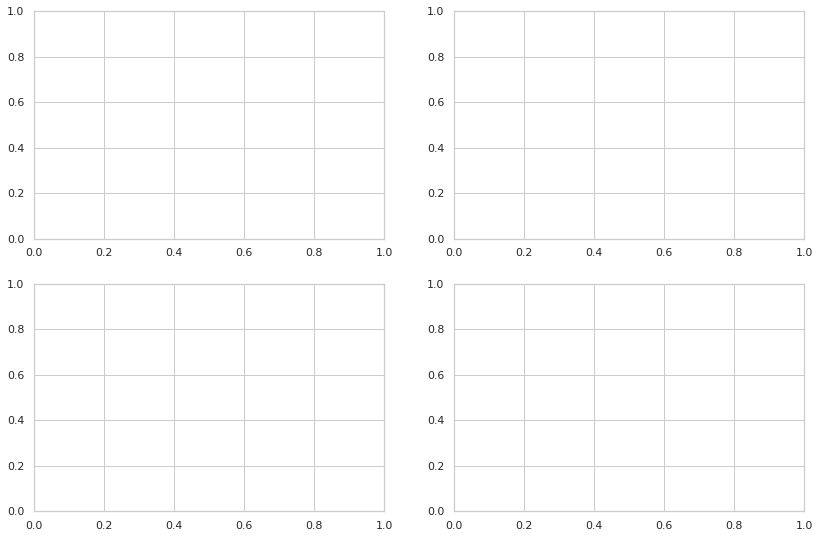

In [234]:
import platform
ax = None
if backend_kwargs is None:
    backend_kwargs = {}

backend_kwargs = {
    **backend_kwarg_defaults(),
    **backend_kwargs,
}

if animation_kwargs is None:
    animation_kwargs = {}
if platform.system() == "Linux":
    animation_kwargs.setdefault("blit", True)
else:
    animation_kwargs.setdefault("blit", False)

if alpha is None:
    if animated:
        alpha = 1
    else:
        if kind.lower() == "scatter":
            alpha = 0.7
        else:
            alpha = 0.2

if jitter is None:
    jitter = 0.0
if jitter < 0.0:
    raise ValueError("jitter must be >=0")

if animated:
    try:
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell" and get_backend() != "nbAgg":
            raise Warning(
                "To run animations inside a notebook you have to use the nbAgg backend. "
                "Try with `%matplotlib notebook` or  `%matplotlib  nbAgg`. You can switch "
                "back to the default backend with `%matplotlib  inline` or "
                "`%matplotlib  auto`."
            )
    except NameError:
        pass

    if animation_kwargs["blit"] and platform.system() != "Linux":
        _log.warning(
            "If you experience problems rendering the animation try setting "
            "`animation_kwargs({'blit':False}) or changing the plotting backend "
            "(e.g. to TkAgg)"
        )

(figsize, ax_labelsize, _, xt_labelsize, linewidth, markersize) = _scale_fig_size(
    figsize, textsize, rows, cols
)
backend_kwargs.setdefault("figsize", figsize)
backend_kwargs.setdefault("squeeze", True)
if ax is None:
    fig, axes = create_axes_grid(length_plotters, rows, cols, backend_kwargs=backend_kwargs)
else:
    axes = np.ravel(ax)
    if len(axes) != length_plotters:
        raise ValueError(
            "Found {} variables to plot but {} axes instances. They must be equal.".format(
                length_plotters, len(axes)
            )
        )
    if animated:
        fig = axes[0].get_figure()
        if not all((ax.get_figure() is fig for ax in axes)):
            raise ValueError("All axes must be on the same figure for animation to work")

In [231]:
length_plotters

4

In [233]:
cols

2

In [232]:
rows

2

In [230]:
len(axes)

1

In [227]:
def _scale_fig_size(figsize, textsize, rows=1, cols=1):
    """Scale figure properties according to rows and cols.
    Parameters
    ----------
    figsize : float or None
        Size of figure in inches
    textsize : float or None
        fontsize
    rows : int
        Number of rows
    cols : int
        Number of columns
    Returns
    -------
    figsize : float or None
        Size of figure in inches
    ax_labelsize : int
        fontsize for axes label
    titlesize : int
        fontsize for title
    xt_labelsize : int
        fontsize for axes ticks
    linewidth : int
        linewidth
    markersize : int
        markersize
    """
    params = mpl.rcParams
    rc_width, rc_height = tuple(params["figure.figsize"])
    rc_ax_labelsize = params["axes.labelsize"]
    rc_titlesize = params["axes.titlesize"]
    rc_xt_labelsize = params["xtick.labelsize"]
    rc_linewidth = params["lines.linewidth"]
    rc_markersize = params["lines.markersize"]
    if isinstance(rc_ax_labelsize, str):
        rc_ax_labelsize = 15
    if isinstance(rc_titlesize, str):
        rc_titlesize = 16
    if isinstance(rc_xt_labelsize, str):
        rc_xt_labelsize = 14

    if figsize is None:
        width, height = rc_width, rc_height
        sff = 1 if (rows == cols == 1) else 1.15
        width = width * cols * sff
        height = height * rows * sff
    else:
        width, height = figsize

    if textsize is not None:
        scale_factor = textsize / rc_xt_labelsize
    elif rows == cols == 1:
        scale_factor = ((width * height) / (rc_width * rc_height)) ** 0.5
    else:
        scale_factor = 1

    ax_labelsize = rc_ax_labelsize * scale_factor
    titlesize = rc_titlesize * scale_factor
    xt_labelsize = rc_xt_labelsize * scale_factor
    linewidth = rc_linewidth * scale_factor
    markersize = rc_markersize * scale_factor

    return (width, height), ax_labelsize, titlesize, xt_labelsize, linewidth, markersize

In [239]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import _pylab_helpers
import matplotlib.ticker as mticker

def plot_kde(
    density,
    lower,
    upper,
    density_q,
    xmin,
    xmax,
    ymin,
    ymax,
    gridsize,
    values,
    values2,
    rug,
    label,
    quantiles,
    rotated,
    contour,
    fill_last,
    figsize,
    textsize,
    plot_kwargs,
    fill_kwargs,
    rug_kwargs,
    contour_kwargs,
    contourf_kwargs,
    pcolormesh_kwargs,
    is_circular,
    ax,
    legend,
    backend_kwargs,
    show,
    return_glyph,  # pylint: disable=unused-argument
):
    """Matplotlib kde plot."""
    if backend_kwargs is None:
        backend_kwargs = {}

    backend_kwargs = {
        **backend_kwarg_defaults(),
        **backend_kwargs,
    }

    figsize, *_, xt_labelsize, linewidth, markersize = _scale_fig_size(figsize, textsize)

    backend_kwargs.setdefault("figsize", figsize)
    backend_kwargs["squeeze"] = True
    backend_kwargs.setdefault("subplot_kw", {})
    backend_kwargs["subplot_kw"].setdefault("polar", is_circular)

    if ax is None:
        fig_manager = _pylab_helpers.Gcf.get_active()
        if fig_manager is not None:
            ax = fig_manager.canvas.figure.gca()
        else:
            _, ax = create_axes_grid(
                1,
                backend_kwargs=backend_kwargs,
            )

    if values2 is None:
        plot_kwargs = matplotlib_kwarg_dealiaser(plot_kwargs, "plot")
        plot_kwargs.setdefault("color", "C0")

        default_color = plot_kwargs.get("color")

        fill_kwargs = matplotlib_kwarg_dealiaser(fill_kwargs, "hexbin")
        fill_kwargs.setdefault("color", default_color)

        rug_kwargs = matplotlib_kwarg_dealiaser(rug_kwargs, "plot")
        rug_kwargs.setdefault("marker", "_" if rotated else "|")
        rug_kwargs.setdefault("linestyle", "None")
        rug_kwargs.setdefault("color", default_color)
        rug_kwargs.setdefault("space", 0.2)

        plot_kwargs.setdefault("linewidth", linewidth)
        rug_kwargs.setdefault("markersize", 2 * markersize)

        rug_space = max(density) * rug_kwargs.pop("space")

        if is_circular:

            if is_circular == "radians":
                labels = [
                    "0",
                    f"{np.pi/4:.2f}",
                    f"{np.pi/2:.2f}",
                    f"{3*np.pi/4:.2f}",
                    f"{np.pi:.2f}",
                    f"{-3*np.pi/4:.2f}",
                    f"{-np.pi/2:.2f}",
                    f"{-np.pi/4:.2f}",
                ]

                ticks_loc = ax.get_xticks()
                ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
                ax.set_xticklabels(labels)

            x = np.linspace(-np.pi, np.pi, len(density))
            ax.set_yticklabels([])

        else:
            x = np.linspace(lower, upper, len(density))

        fill_func = ax.fill_between
        fill_x, fill_y = x, density
        if rotated:
            x, density = density, x
            fill_func = ax.fill_betweenx

        ax.tick_params(labelsize=xt_labelsize)

        if rotated:
            ax.set_xlim(0, auto=True)
            rug_x, rug_y = np.zeros_like(values) - rug_space, values
        else:
            ax.set_ylim(0, auto=True)
            rug_x, rug_y = values, np.zeros_like(values) - rug_space

        if rug:
            ax.plot(rug_x, rug_y, **rug_kwargs)

        if quantiles is not None:
            fill_kwargs.setdefault("alpha", 0.75)

            idx = [np.sum(density_q < quant) for quant in quantiles]

            fill_func(
                fill_x,
                fill_y,
                where=np.isin(fill_x, fill_x[idx], invert=True, assume_unique=True),
                **fill_kwargs,
            )
        else:
            fill_kwargs.setdefault("alpha", 0)
            if fill_kwargs.get("alpha") == 0:
                label = plot_kwargs.setdefault("label", label)
                ax.plot(x, density, **plot_kwargs)
                fill_func(fill_x, fill_y, **fill_kwargs)
            else:
                label = fill_kwargs.setdefault("label", label)
                ax.plot(x, density, **plot_kwargs)
                fill_func(fill_x, fill_y, **fill_kwargs)
        if legend and label:
            ax.legend()
    else:
        contour_kwargs = matplotlib_kwarg_dealiaser(contour_kwargs, "contour")
        contour_kwargs.setdefault("colors", "0.5")
        contourf_kwargs = matplotlib_kwarg_dealiaser(contourf_kwargs, "contour")
        pcolormesh_kwargs = matplotlib_kwarg_dealiaser(pcolormesh_kwargs, "pcolormesh")

        g_s = complex(gridsize[0])
        x_x, y_y = np.mgrid[xmin:xmax:g_s, ymin:ymax:g_s]

        ax.grid(False)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        if contour:
            qcfs = ax.contourf(x_x, y_y, density, antialiased=True, **contourf_kwargs)
            qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
            if not fill_last:
                qcfs.collections[0].set_alpha(0)
                qcs.collections[0].set_alpha(0)
        else:
            ax.pcolormesh(x_x, y_y, density, **pcolormesh_kwargs)

    if backend_show(show):
        plt.show()

    return ax

In [190]:
length_plotters

4

In [203]:
i = 0
var_name, selection, isel, obs_vals = obs_plotters[i]

In [204]:
var_name

'subj0_HC_rt'

In [205]:
selection

{}

In [206]:
isel

{}

In [207]:
obs_vals

array([ 1.21 ,  1.03 , -1.14 ,  2.   ,  0.857,  1.72 ,  1.72 ,  1.72 ,
       -2.44 , -0.987,  2.38 , -1.17 , -1.88 ,  0.972, -2.84 ,  2.3  ,
        2.35 ,  1.7  ,  1.46 ,  1.96 ,  2.76 , -2.15 , -3.15 , -1.38 ,
       -1.38 ,  3.17 ,  0.946, -3.83 ,  1.2  ,  1.2  , -1.49 , -1.56 ,
        0.886, -1.84 ,  0.968,  0.841, -1.96 , -2.35 , -2.87 , -3.23 ,
       -3.66 , -1.98 , -0.602,  0.947, -1.25 ,  0.95 , -2.17 , -1.98 ,
       -1.1  ,  2.2  , -2.72 , -1.04 , -1.93 ,  1.95 ,  1.5  , -1.87 ,
       -1.65 ,  1.56 ,  1.15 ,  3.86 ,  0.814,  1.08 ,  2.03 , -1.59 ,
        1.63 , -1.95 ,  2.02 ,  1.36 , -2.07 ,  1.75 ,  1.15 , -1.14 ,
        2.34 ])

In [208]:
pp_var_name, _, _, pp_vals = pp_plotters[i]

In [209]:
pp_var_name

'subj0_HC_rt'

In [210]:
pp_vals

array([[[-3.82283542,  1.49434139, -1.57898587, ..., -1.398955  ,
         -1.44385706, -0.99055113],
        [-2.12128315,  1.16686022, -1.26058812, ...,  1.33296851,
          1.20857451,  2.75555919],
        [ 2.12832162,  1.64529016,  1.67490756, ...,  1.59976289,
          1.75015385,  1.52606476],
        ...,
        [-1.3837376 , -1.66641283,  1.21008088, ...,  2.67436288,
         -2.35344212,  1.60947511],
        [ 3.16176606,  1.32616984,  2.05014697, ...,  1.57013259,
          3.2826022 , -1.04357159],
        [ 1.02874084,  1.26341332,  2.12180841, ..., -1.47207685,
          5.15091573, -1.2110603 ]],

       [[ 2.5584844 ,  1.18432221, -2.68369288, ...,  1.16382141,
          2.01203696,  1.5068893 ],
        [-1.23400722, -0.93078506, -1.73089772, ...,  1.99228863,
          4.01743345, -1.64744543],
        [-1.57835561,  1.06881492, -1.27919304, ...,  1.82078637,
         -2.12170673, -1.1303828 ],
        ...,
        [ 3.37717061,  1.16992879, -1.31162389, ...,  

In [211]:
dtype = predictive_dataset[pp_var_name].dtype.kind

KeyError: 'subj0_HC_rt'

In [194]:
rows = 2

In [193]:
cols = 2

In [220]:
backend_kwargs = {**backend_kwarg_defaults(), **backend_kwargs}
print(backend_kwargs)

TypeError: 'NoneType' object is not a mapping

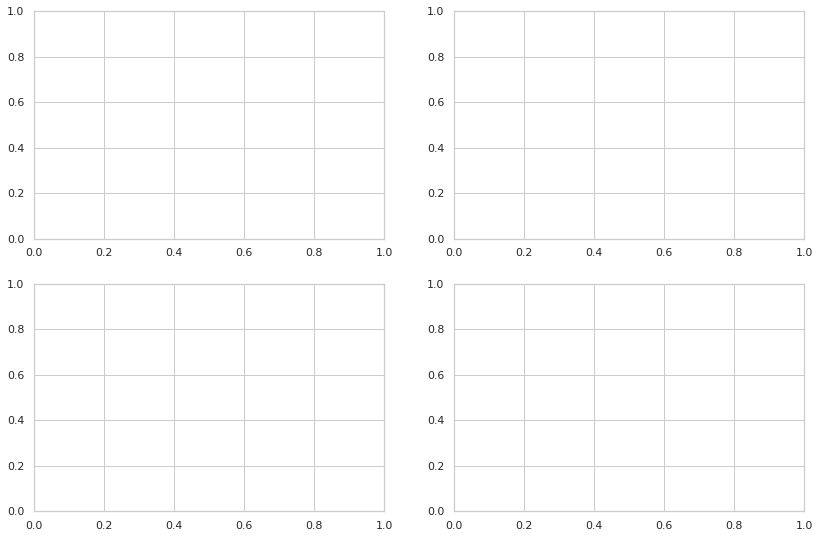

In [238]:
import matplotlib as mpl

from matplotlib.cbook import normalize_kwargs
from matplotlib.pyplot import subplots
from numpy import ndenumerate

def backend_kwarg_defaults(*args, **kwargs):
    """Get default kwargs for backend.
    For args add a tuple with key and rcParam key pair.
    """
    defaults = {**kwargs}
    # add needed default args from arviz.rcParams
    for key, arg in args:
        defaults.setdefault(key, rcParams[arg])
    return defaults

def backend_show(show):
    """Set default behaviour for show if not explicitly defined."""
    if show is None:
        show = rcParams["plot.matplotlib.show"]
    return show


def create_axes_grid(length_plotters, rows=1, cols=1, backend_kwargs=None):
    """Create figure and axes for grids with multiple plots.
    Parameters
    ----------
    length_plotters : int
        Number of axes required
    rows : int
        Number of rows
    cols : int
        Number of columns
    backend_kwargs: dict, optional
        kwargs for backend figure.
    Returns
    -------
    fig : matplotlib figure
    ax : matplotlib axes
    """
    if backend_kwargs is None:
        backend_kwargs = {}

    backend_kwargs = {**backend_kwarg_defaults(), **backend_kwargs}

    fig, axes = subplots(rows, cols, **backend_kwargs)
    extra = (rows * cols) - length_plotters
    if extra > 0:
        for (row, col), ax in ndenumerate(axes):
            if (row * cols + col + 1) > length_plotters:
                ax.set_axis_off()
    return fig, axes

def matplotlib_kwarg_dealiaser(args, kind):
    """De-aliase the kwargs passed to plots."""
    if args is None:
        return {}
    matplotlib_kwarg_dealiaser_dict = {
        "scatter": mpl.collections.PathCollection,
        "plot": mpl.lines.Line2D,
        "hist": mpl.patches.Patch,
        "bar": mpl.patches.Rectangle,
        "hexbin": mpl.collections.PolyCollection,
        "fill_between": mpl.collections.PolyCollection,
        "hlines": mpl.collections.LineCollection,
        "text": mpl.text.Text,
        "contour": mpl.contour.ContourSet,
        "pcolormesh": mpl.collections.QuadMesh,
    }
    return normalize_kwargs(args, getattr(matplotlib_kwarg_dealiaser_dict[kind], "_alias_map", {}))



fig, axes = create_axes_grid(length_plotters, rows, cols, backend_kwargs=backend_kwargs)

In [98]:
type(pp_plotters[0][3])

numpy.ndarray

In [137]:
pp_plotters[0]

('rt',
 {},
 {},
 array([[[-3.82283542,  1.48361254,  1.49434139, ...,  1.66304016,
           1.87431575,  1.13547581],
         [-2.12128315,  1.56989023,  1.16686022, ...,  3.75927011,
           2.42931053,  1.86512251],
         [ 2.12832162,  1.5645146 ,  1.64529016, ...,  2.46169728,
          -4.42331745,  1.9520246 ],
         ...,
         [-1.3837376 , -2.34244127, -1.66641283, ...,  1.02595796,
           1.05339185,  1.79269716],
         [ 3.16176606,  3.76104091,  1.32616984, ...,  1.36070194,
          -1.16075935,  0.76698501],
         [ 1.02874084,  1.10295848,  1.26341332, ...,  2.18816383,
           3.59614004,  0.88263177]],
 
        [[ 2.5584844 , -2.19345862,  1.18432221, ...,  4.25143896,
          -1.18078109,  1.21617012],
         [-1.23400722,  1.36286823, -0.93078506, ..., -1.43115177,
          -1.63004882, -1.87250654],
         [-1.57835561, -1.37243386,  1.06881492, ...,  2.37752924,
           2.985057  ,  0.67069799],
         ...,
         [ 3.377

In [104]:
type(pp_plotters[0][3])

numpy.ndarray

In [130]:
len(pp_plotters[0][3])

4

In [105]:
type(pp_plotters[0][3][0])

numpy.ndarray

In [138]:
len(pp_plotters[0][3][0])

1000

In [139]:
pp_plotters[0][3][0]

array([[-3.82283542,  1.48361254,  1.49434139, ...,  1.66304016,
         1.87431575,  1.13547581],
       [-2.12128315,  1.56989023,  1.16686022, ...,  3.75927011,
         2.42931053,  1.86512251],
       [ 2.12832162,  1.5645146 ,  1.64529016, ...,  2.46169728,
        -4.42331745,  1.9520246 ],
       ...,
       [-1.3837376 , -2.34244127, -1.66641283, ...,  1.02595796,
         1.05339185,  1.79269716],
       [ 3.16176606,  3.76104091,  1.32616984, ...,  1.36070194,
        -1.16075935,  0.76698501],
       [ 1.02874084,  1.10295848,  1.26341332, ...,  2.18816383,
         3.59614004,  0.88263177]])

In [140]:
pp_plotters[0][3][1]

array([[ 2.5584844 , -2.19345862,  1.18432221, ...,  4.25143896,
        -1.18078109,  1.21617012],
       [-1.23400722,  1.36286823, -0.93078506, ..., -1.43115177,
        -1.63004882, -1.87250654],
       [-1.57835561, -1.37243386,  1.06881492, ...,  2.37752924,
         2.985057  ,  0.67069799],
       ...,
       [ 3.37717061, -1.49829264,  1.16992879, ...,  3.38817137,
         3.32828592,  2.68205826],
       [ 1.51807487,  1.16386873, -1.18941335, ..., -3.26371695,
        -1.56281022,  1.35949057],
       [ 5.21509315,  1.33024086, -1.14640476, ..., -2.57418785,
         1.90860968, -3.12894203]])

In [71]:
grid=None
rows, cols = default_grid(length_plotters, grid=grid)
print(rows)
print(cols)

1
2


In [82]:
backend

'matplotlib'

In [89]:
print(az.__file__)

/opt/conda/lib/python3.7/site-packages/arviz/__init__.py


In [88]:

plot = get_plotting_function("plot_ppc", "ppcplot", backend)
axes = plot(**ppcplot_kwargs)
axes

TypeError: plot_ppc() missing 1 required positional argument: 'color'

In [40]:
from typing import Union
class BaseLabeller:
    """WIP."""

    def dim_coord_to_str(self, dim, coord_val, coord_idx):
        """WIP."""
        return f"{coord_val}"

    def sel_to_str(self, sel: dict, isel: dict):
        """WIP."""
        if not sel:
            return ""
        return ", ".join(
            [
                self.dim_coord_to_str(dim, v, i)
                for (dim, v), (_, i) in zip(sel.items(), isel.items())
            ]
        )

    def var_name_to_str(self, var_name: Union[str, None]):
        """WIP."""
        return var_name

    def var_pp_to_str(self, var_name, pp_var_name):
        """WIP."""
        var_name_str = self.var_name_to_str(var_name)
        pp_var_name_str = self.var_name_to_str(pp_var_name)
        return f"{var_name_str} / {pp_var_name_str}"

    def model_name_to_str(self, model_name):
        """WIP."""
        return model_name

    def make_label_vert(self, var_name: Union[str, None], sel: dict, isel: dict):
        """WIP."""
        var_name_str = self.var_name_to_str(var_name)
        sel_str = self.sel_to_str(sel, isel)
        if not sel_str:
            return var_name_str
        if var_name_str is None:
            return sel_str
        return f"{var_name_str}\n{sel_str}"

    def make_label_flat(self, var_name: str, sel: dict, isel: dict):
        """WIP."""
        var_name_str = self.var_name_to_str(var_name)
        sel_str = self.sel_to_str(sel, isel)
        if not sel_str:
            return var_name_str
        if var_name is None:
            return sel_str
        return f"{var_name_str}[{sel_str}]"

    def make_pp_label(self, var_name, pp_var_name, sel, isel):
        """WIP."""
        names = self.var_pp_to_str(var_name, pp_var_name)
        return self.make_label_vert(names, sel, isel)

    def make_model_label(self, model_name, label):
        """WIP."""
        model_name_str = self.model_name_to_str(model_name)
        if model_name_str is None:
            return label
        return f"{model_name}: {label}"

In [41]:
def plot_ppc(
    data,
    kind="kde",
    alpha=None,
    mean=True,
    observed=True,
    color=None,
    colors=None,
    grid=None,
    figsize=None,
    textsize=None,
    data_pairs=None,
    var_names=None,
    filter_vars=None,
    coords=None,
    flatten=None,
    flatten_pp=None,
    num_pp_samples=None,
    random_seed=None,
    jitter=None,
    animated=False,
    animation_kwargs=None,
    legend=True,
    labeller=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    group="posterior",
    show=None,
):
    """
    Plot for posterior/prior predictive checks.
    Parameters
    ----------
    data: az.InferenceData object
        :class:`arviz.InferenceData` object containing the observed and posterior/prior
        predictive data.
    kind: str
        Type of plot to display ("kde", "cumulative", or "scatter"). Defaults to `kde`.
    alpha: float
        Opacity of posterior/prior predictive density curves.
        Defaults to 0.2 for ``kind = kde`` and cumulative, for scatter defaults to 0.7.
    mean: bool
        Whether or not to plot the mean posterior/prior predictive distribution.
        Defaults to ``True``.
    observed: bool, default True
        Whether or not to plot the observed data.
    color: str
        Valid matplotlib ``color``. Defaults to ``C0``.
    color: list
        List with valid matplotlib colors corresponding to the posterior/prior predictive
        distribution, observed data and mean of the posterior/prior predictive distribution.
        Defaults to ["C0", "k", "C1"].
    grid : tuple
        Number of rows and columns. Defaults to None, the rows and columns are
        automatically inferred.
    figsize: tuple
        Figure size. If None, it will be defined automatically.
    textsize: float
        Text size scaling factor for labels, titles and lines. If None, it will be
        autoscaled based on ``figsize``.
    data_pairs: dict
        Dictionary containing relations between observed data and posterior/prior predictive data.
        Dictionary structure:
        - key = data var_name
        - value = posterior/prior predictive var_name
        For example, ``data_pairs = {'y' : 'y_hat'}``
        If None, it will assume that the observed data and the posterior/prior
        predictive data have the same variable name.
    var_names: list of variable names
        Variables to be plotted, if `None` all variable are plotted. Prefix the
        variables by ``~`` when you want to exclude them from the plot.
    filter_vars: {None, "like", "regex"}, optional, default=None
        If `None` (default), interpret var_names as the real variables names. If "like",
        interpret var_names as substrings of the real variables names. If "regex",
        interpret var_names as regular expressions on the real variables names. A la
        ``pandas.filter``.
    coords: dict
        Dictionary mapping dimensions to selected coordinates to be plotted.
        Dimensions without a mapping specified will include all coordinates for
        that dimension. Defaults to including all coordinates for all
        dimensions if None.
    flatten: list
        List of dimensions to flatten in ``observed_data``. Only flattens across the coordinates
        specified in the ``coords`` argument. Defaults to flattening all of the dimensions.
    flatten_pp: list
        List of dimensions to flatten in posterior_predictive/prior_predictive. Only flattens
        across the coordinates specified in the ``coords`` argument. Defaults to flattening all
        of the dimensions. Dimensions should match flatten excluding dimensions for ``data_pairs``
        parameters. If ``flatten`` is defined and ``flatten_pp`` is None, then
        ``flatten_pp = flatten``.
    num_pp_samples: int
        The number of posterior/prior predictive samples to plot. For ``kind`` = 'scatter' and
        ``animation = False`` if defaults to a maximum of 5 samples and will set jitter to 0.7.
        unless defined. Otherwise it defaults to all provided samples.
    random_seed: int
        Random number generator seed passed to ``numpy.random.seed`` to allow
        reproducibility of the plot. By default, no seed will be provided
        and the plot will change each call if a random sample is specified
        by ``num_pp_samples``.
    jitter: float
        If ``kind`` is "scatter", jitter will add random uniform noise to the height
        of the ppc samples and observed data. By default 0.
    animated: bool
        Create an animation of one posterior/prior predictive sample per frame.
        Defaults to ``False``. Only works with matploblib backend.
        To run animations inside a notebook you have to use the `nbAgg` matplotlib's backend.
        Try with `%matplotlib notebook` or  `%matplotlib  nbAgg`. You can switch back to the
        default matplotlib's backend with `%matplotlib  inline` or `%matplotlib  auto`.
        If switching back and forth between matplotlib's backend, you may need to run twice the cell
        with the animation.
        If you experience problems rendering the animation try setting
        `animation_kwargs({'blit':False}) or changing the matplotlib's backend (e.g. to TkAgg)
        If you run the animation from a script write `ax, ani = az.plot_ppc(.)`
    animation_kwargs : dict
        Keywords passed to  :class:`matplotlib.animation.FuncAnimation`. Ignored with
        matplotlib backend.
    legend : bool
        Add legend to figure. By default ``True``.
    labeller : labeller instance, optional
        Class providing the method ``make_pp_label`` to generate the labels in the plot titles.
        Read the :ref:`label_guide` for more details and usage examples.
    ax: numpy array-like of matplotlib axes or bokeh figures, optional
        A 2D array of locations into which to plot the densities. If not supplied, Arviz will create
        its own array of plot areas (and return it).
    backend: str, optional
        Select plotting backend {"matplotlib","bokeh"}. Default to "matplotlib".
    backend_kwargs: bool, optional
        These are kwargs specific to the backend being used, passed to
        :func:`matplotlib.pyplot.subplots` or :func:`bokeh.plotting.figure`.
        For additional documentation check the plotting method of the backend.
    group: {"prior", "posterior"}, optional
        Specifies which InferenceData group should be plotted. Defaults to 'posterior'.
        Other value can be 'prior'.
    show: bool, optional
        Call backend show function.
    Returns
    -------
    axes: matplotlib axes or bokeh figures
    See Also
    --------
    plot_bpv: Plot Bayesian p-value for observed data and Posterior/Prior predictive.
    plot_lm: Posterior predictive and mean plots for regression-like data.
    plot_ppc: plot for posterior/prior predictive checks.
    plot_ts: Plot timeseries data.
    Examples
    --------
    Plot the observed data KDE overlaid on posterior predictive KDEs.
    .. plot::
        :context: close-figs
        >>> import arviz as az
        >>> data = az.load_arviz_data('radon')
        >>> az.plot_ppc(data, data_pairs={"y":"y"})
    Plot the overlay with empirical CDFs.
    .. plot::
        :context: close-figs
        >>> az.plot_ppc(data, kind='cumulative')
    Use the ``coords`` and ``flatten`` parameters to plot selected variable dimensions
    across multiple plots. We will now modify the dimension ``obs_id`` to contain
    indicate the name of the county where the measure was taken. The change has to
    be done on both ``posterior_predictive`` and ``observed_data`` groups, which is
    why we will use :meth:`~arviz.InferenceData.map` to apply the same function to
    both groups. Afterwards, we will select the counties to be plotted with the
    ``coords`` arg.
    .. plot::
        :context: close-figs
        >>> obs_county = data.posterior["County"][data.constant_data["county_idx"]]
        >>> data = data.assign_coords(obs_id=obs_county, groups="observed_vars")
        >>> az.plot_ppc(data, coords={'obs_id': ['ANOKA', 'BELTRAMI']}, flatten=[])
    Plot the overlay using a stacked scatter plot that is particularly useful
    when the sample sizes are small.
    .. plot::
        :context: close-figs
        >>> az.plot_ppc(data, kind='scatter', flatten=[],
        >>>             coords={'obs_id': ['AITKIN', 'BELTRAMI']})
    Plot random posterior predictive sub-samples.
    .. plot::
        :context: close-figs
        >>> az.plot_ppc(data, num_pp_samples=30, random_seed=7)
    """
    if group not in ("posterior", "prior"):
        raise TypeError("`group` argument must be either `posterior` or `prior`")

    for groups in (f"{group}_predictive", "observed_data"):
        if not hasattr(data, groups):
            raise TypeError(f'`data` argument must have the group "{groups}" for ppcplot')

    if kind.lower() not in ("kde", "cumulative", "scatter"):
        raise TypeError("`kind` argument must be either `kde`, `cumulative`, or `scatter`")

    if colors is None:
        colors = ["C0", "k", "C1"]

    if isinstance(colors, str):
        raise TypeError("colors should be a list with 3 items.")

    if len(colors) != 3:
        raise ValueError("colors should be a list with 3 items.")

    if color is not None:
        warnings.warn("color has been deprecated in favor of colors", FutureWarning)
        colors[0] = color

    if data_pairs is None:
        data_pairs = {}

    if backend is None:
        backend = rcParams["plot.backend"]
    backend = backend.lower()
    if backend == "bokeh":
        if animated:
            raise TypeError("Animation option is only supported with matplotlib backend.")

    observed_data = data.observed_data

    if group == "posterior":
        predictive_dataset = data.posterior_predictive
    elif group == "prior":
        predictive_dataset = data.prior_predictive

    if var_names is None:
        var_names = list(observed_data.data_vars)
    var_names = _var_names(var_names, observed_data, filter_vars)
    pp_var_names = [data_pairs.get(var, var) for var in var_names]
    pp_var_names = _var_names(pp_var_names, predictive_dataset, filter_vars)

    if flatten_pp is None and flatten is None:
        flatten_pp = list(predictive_dataset.dims.keys())
    elif flatten_pp is None:
        flatten_pp = flatten
    if flatten is None:
        flatten = list(observed_data.dims.keys())

    if coords is None:
        coords = {}

    if labeller is None:
        labeller = BaseLabeller()

    if random_seed is not None:
        np.random.seed(random_seed)

    total_pp_samples = predictive_dataset.sizes["chain"] * predictive_dataset.sizes["draw"]
    if num_pp_samples is None:
        if kind == "scatter" and not animated:
            num_pp_samples = min(5, total_pp_samples)
        else:
            num_pp_samples = total_pp_samples

    if (
        not isinstance(num_pp_samples, Integral)
        or num_pp_samples < 1
        or num_pp_samples > total_pp_samples
    ):
        raise TypeError(
            "`num_pp_samples` must be an integer between 1 and " + f"{total_pp_samples}."
        )

    pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

    for key in coords.keys():
        coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]

    obs_plotters = filter_plotters_list(
        list(
            xarray_var_iter(
                observed_data.isel(coords),
                skip_dims=set(flatten),
                var_names=var_names,
                combined=True,
            )
        ),
        "plot_ppc",
    )
    length_plotters = len(obs_plotters)
    pp_plotters = [
        tup
        for _, tup in zip(
            range(length_plotters),
            xarray_var_iter(
                predictive_dataset.isel(coords),
                var_names=pp_var_names,
                skip_dims=set(flatten_pp),
                combined=True,
            ),
        )
    ]
    rows, cols = default_grid(length_plotters, grid=grid)

    ppcplot_kwargs = dict(
        ax=ax,
        length_plotters=length_plotters,
        rows=rows,
        cols=cols,
        figsize=figsize,
        animated=animated,
        obs_plotters=obs_plotters,
        pp_plotters=pp_plotters,
        predictive_dataset=predictive_dataset,
        pp_sample_ix=pp_sample_ix,
        kind=kind,
        alpha=alpha,
        colors=colors,
        jitter=jitter,
        textsize=textsize,
        mean=mean,
        observed=observed,
        total_pp_samples=total_pp_samples,
        legend=legend,
        labeller=labeller,
        group=group,
        animation_kwargs=animation_kwargs,
        num_pp_samples=num_pp_samples,
        backend_kwargs=backend_kwargs,
        show=show,
    )

    # TODO: Add backend kwargs
    plot = get_plotting_function("plot_ppc", "ppcplot", backend)
    axes = plot(**ppcplot_kwargs)
    return axes

In [42]:
import importlib
def get_plotting_function(plot_name, plot_module, backend):
    """Return plotting function for correct backend."""
    _backend = {
        "mpl": "matplotlib",
        "bokeh": "bokeh",
        "matplotlib": "matplotlib",
    }

    if backend is None:
        backend = rcParams["plot.backend"]
    backend = backend.lower()

    try:
        backend = _backend[backend]
    except KeyError as err:
        raise KeyError(
            "Backend {} is not implemented. Try backend in {}".format(
                backend, set(_backend.values())
            )
        ) from err

    if backend == "bokeh":
        try:
            import bokeh

            assert packaging.version.parse(bokeh.__version__) >= packaging.version.parse("1.4.0")

        except (ImportError, AssertionError) as err:
            raise ImportError(
                "'bokeh' backend needs Bokeh (1.4.0+) installed." " Please upgrade or install"
            ) from err

    # Perform import of plotting method
    # TODO: Convert module import to top level for all plots
    module = importlib.import_module(f"arviz.plots.backends.{backend}.{plot_module}")

    plotting_method = getattr(module, plot_name)

    return plotting_method

In [43]:
def default_grid(n_items, grid=None, max_cols=4, min_cols=3):  # noqa: D202
    """Make a grid for subplots.
    Tries to get as close to sqrt(n_items) x sqrt(n_items) as it can,
    but allows for custom logic
    Parameters
    ----------
    n_items : int
        Number of panels required
    grid : tuple
        Number of rows and columns
    max_cols : int
        Maximum number of columns, inclusive
    min_cols : int
        Minimum number of columns, inclusive
    Returns
    -------
    (int, int)
        Rows and columns, so that rows * columns >= n_items
    """

    if grid is None:

        def in_bounds(val):
            return np.clip(val, min_cols, max_cols)

        if n_items <= max_cols:
            return 1, n_items
        ideal = in_bounds(round(n_items ** 0.5))

        for offset in (0, 1, -1, 2, -2):
            cols = in_bounds(ideal + offset)
            rows, extra = divmod(n_items, cols)
            if extra == 0:
                return rows, cols
        return n_items // ideal + 1, ideal
    else:
        rows, cols = grid
        if rows * cols < n_items:
            raise ValueError("The number of rows times columns is less than the number of subplots")
        if (rows * cols) - n_items >= cols:
            warnings.warn("The number of rows times columns is larger than necessary")
        return rows, cols

from rcparams import rcParams

def filter_plotters_list(plotters, plot_kind):
    """Cut list of plotters so that it is at most of length "plot.max_subplots"."""
    max_plots = rcParams["plot.max_subplots"]
    max_plots = len(plotters) if max_plots is None else max_plots
    if len(plotters) > max_plots:
        warnings.warn(
            "rcParams['plot.max_subplots'] ({max_plots}) is smaller than the number "
            "of variables to plot ({len_plotters}) in {plot_kind}, generating only "
            "{max_plots} plots".format(
                max_plots=max_plots, len_plotters=len(plotters), plot_kind=plot_kind
            ),
            UserWarning,
        )
        return plotters[:max_plots]
    return plotters

def _dims(data, var_name, skip_dims):
    return [dim for dim in data[var_name].dims if dim not in skip_dims]

from itertools import product, tee
def _zip_dims(new_dims, vals):
    return [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]

def xarray_sel_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    """Convert xarray data to an iterator over variable names and selections.
    Iterates over each var_name and all of its coordinates, returning the variable
    names and selections that allow properly obtain the data from ``data`` as desired.
    Parameters
    ----------
    data : xarray.Dataset
        Posterior data in an xarray
    var_names : iterator of strings (optional)
        Should be a subset of data.data_vars. Defaults to all of them.
    combined : bool
        Whether to combine chains or leave them separate
    skip_dims : set
        dimensions to not iterate over
    reverse_selections : bool
        Whether to reverse selections before iterating.
    Returns
    -------
    Iterator of (var_name: str, selection: dict(str, any))
        The string is the variable name, the dictionary are coordinate names to values,.
        To get the values of the variable at these coordinates, do
        ``data[var_name].sel(**selection)``.
    """
    if skip_dims is None:
        skip_dims = set()

    if combined:
        skip_dims = skip_dims.union({"chain", "draw"})
    else:
        skip_dims.add("draw")

    if var_names is None:
        if isinstance(data, xr.Dataset):
            var_names = list(data.data_vars)
        elif isinstance(data, xr.DataArray):
            var_names = [data.name]
            data = {data.name: data}

    for var_name in var_names:
        if var_name in data:
            new_dims = _dims(data, var_name, skip_dims)
            vals = [purge_duplicates(data[var_name][dim].values) for dim in new_dims]
            dims = _zip_dims(new_dims, vals)
            idims = _zip_dims(new_dims, [range(len(v)) for v in vals])
            if reverse_selections:
                dims = reversed(dims)
                idims = reversed(idims)

            for selection, iselection in zip(dims, idims):
                yield var_name, selection, iselection

def xarray_var_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    """Convert xarray data to an iterator over vectors.
    Iterates over each var_name and all of its coordinates, returning the 1d
    data.
    Parameters
    ----------
    data : xarray.Dataset
        Posterior data in an xarray
    var_names : iterator of strings (optional)
        Should be a subset of data.data_vars. Defaults to all of them.
    combined : bool
        Whether to combine chains or leave them separate
    skip_dims : set
        dimensions to not iterate over
    reverse_selections : bool
        Whether to reverse selections before iterating.
    Returns
    -------
    Iterator of (str, dict(str, any), np.array)
        The string is the variable name, the dictionary are coordinate names to values,
        and the array are the values of the variable at those coordinates.
    """
    data_to_sel = data
    if var_names is None and isinstance(data, xr.DataArray):
        data_to_sel = {data.name: data}

    for var_name, selection, iselection in xarray_sel_iter(
        data,
        var_names=var_names,
        combined=combined,
        skip_dims=skip_dims,
        reverse_selections=reverse_selections,
    ):
        yield var_name, selection, iselection, data_to_sel[var_name].sel(**selection).values


In [44]:
def _subset_list(subset, whole_list, filter_items=None, warn=True):
    """Handle list subsetting (var_names, groups...) across arviz.
    Parameters
    ----------
    subset : str, list, or None
    whole_list : list
        List from which to select a subset according to subset elements and
        filter_items value.
    filter_items : {None, "like", "regex"}, optional
        If `None` (default), interpret `subset` as the exact elements in `whole_list`
        names. If "like", interpret `subset` as substrings of the elements in
        `whole_list`. If "regex", interpret `subset` as regular expressions to match
        elements in `whole_list`. A la `pandas.filter`.
    Returns
    -------
    list or None
        A subset of ``whole_list`` fulfilling the requests imposed by ``subset``
        and ``filter_items``.
    """
    if subset is not None:

        if isinstance(subset, str):
            subset = [subset]

        whole_list_tilde = [item for item in whole_list if item.startswith("~")]
        if whole_list_tilde and warn:
            warnings.warn(
                "ArviZ treats '~' as a negation character for selection. There are "
                "elements in `whole_list` starting with '~', {0}. Please double check"
                "your results to ensure all elements are included".format(
                    ", ".join(whole_list_tilde)
                )
            )

        excluded_items = [
            item[1:] for item in subset if item.startswith("~") and item not in whole_list
        ]
        filter_items = str(filter_items).lower()
        not_found = []

        if excluded_items:
            if filter_items in ("like", "regex"):
                for pattern in excluded_items[:]:
                    excluded_items.remove(pattern)
                    if filter_items == "like":
                        real_items = [real_item for real_item in whole_list if pattern in real_item]
                    else:
                        # i.e filter_items == "regex"
                        real_items = [
                            real_item for real_item in whole_list if re.search(pattern, real_item)
                        ]
                    if not real_items:
                        not_found.append(pattern)
                    excluded_items.extend(real_items)
            not_found.extend([item for item in excluded_items if item not in whole_list])
            if not_found:
                warnings.warn(
                    f"Items starting with ~: {not_found} have not been found and will be ignored"
                )
            subset = [item for item in whole_list if item not in excluded_items]

        else:
            if filter_items == "like":
                subset = [item for item in whole_list for name in subset if name in item]
            elif filter_items == "regex":
                subset = [item for item in whole_list for name in subset if re.search(name, item)]

        existing_items = np.isin(subset, whole_list)
        if not np.all(existing_items):
            raise KeyError(f"{np.array(subset)[~existing_items]} are not present")

    return subset

def _var_names(var_names, data, filter_vars=None):
    """Handle var_names input across arviz.
    Parameters
    ----------
    var_names: str, list, or None
    data : xarray.Dataset
        Posterior data in an xarray
    filter_vars: {None, "like", "regex"}, optional, default=None
        If `None` (default), interpret var_names as the real variables names. If "like",
         interpret var_names as substrings of the real variables names. If "regex",
         interpret var_names as regular expressions on the real variables names. A la
        `pandas.filter`.
    Returns
    -------
    var_name: list or None
    """
    if filter_vars not in {None, "like", "regex"}:
        raise ValueError(
            f"'filter_vars' can only be None, 'like', or 'regex', got: '{filter_vars}'"
        )

    if var_names is not None:
        if isinstance(data, (list, tuple)):
            all_vars = []
            for dataset in data:
                dataset_vars = list(dataset.data_vars)
                for var in dataset_vars:
                    if var not in all_vars:
                        all_vars.append(var)
        else:
            all_vars = list(data.data_vars)

        all_vars_tilde = [var for var in all_vars if var.startswith("~")]
        if all_vars_tilde:
            warnings.warn(
                """ArviZ treats '~' as a negation character for variable selection.
                   Your model has variables names starting with '~', {0}. Please double check
                   your results to ensure all variables are included""".format(
                    ", ".join(all_vars_tilde)
                )
            )

        try:
            var_names = _subset_list(var_names, all_vars, filter_items=filter_vars, warn=False)
        except KeyError as err:
            msg = " ".join(("var names:", f"{err}", "in dataset"))
            raise KeyError(msg) from err
    return var_names

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c51523750>,
      dtype=object)

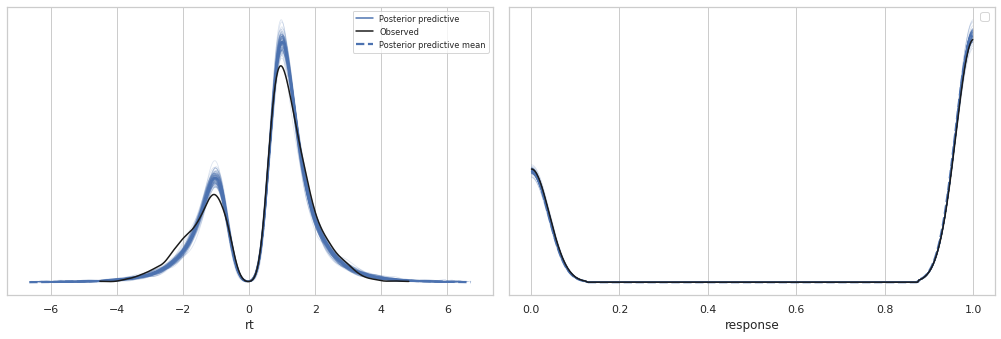

In [28]:
az.plot_ppc(InfData['ms2'], num_pp_samples=100, random_seed=7)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c50945590>,
      dtype=object)

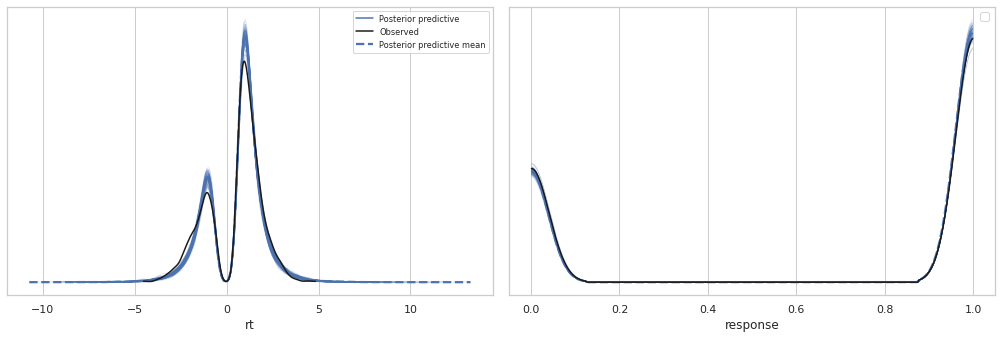

In [29]:
az.plot_ppc(InfData['ms3'], num_pp_samples=100, random_seed=7)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bdbc3add0>,
      dtype=object)

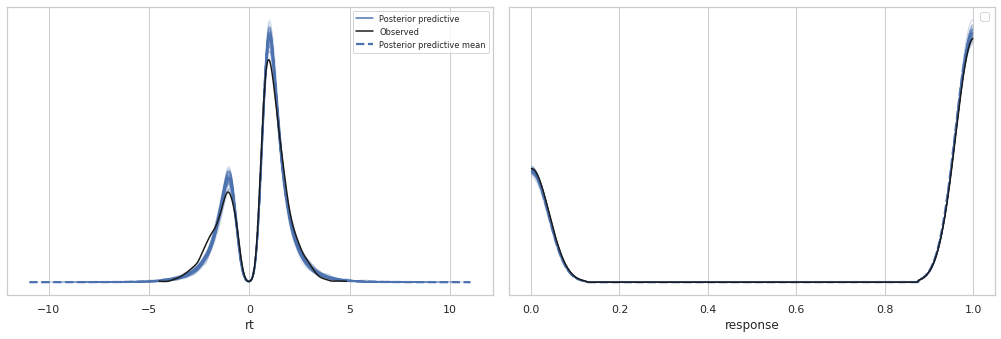

In [31]:
az.plot_ppc(InfData['ms7'], num_pp_samples=100, random_seed=7)

## Step 9: Statistical inference and interpretation



## Step 10: Reporting